<a href="https://colab.research.google.com/github/Nicokac/ProyectoFinal_DataScience/blob/main/ProyectoFinal_DataScience_Kachuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de análisis y de creación de modelos de predicción del precio del Bitcoin utilizando machine learning
  - Creador: Nicolás Kachuk

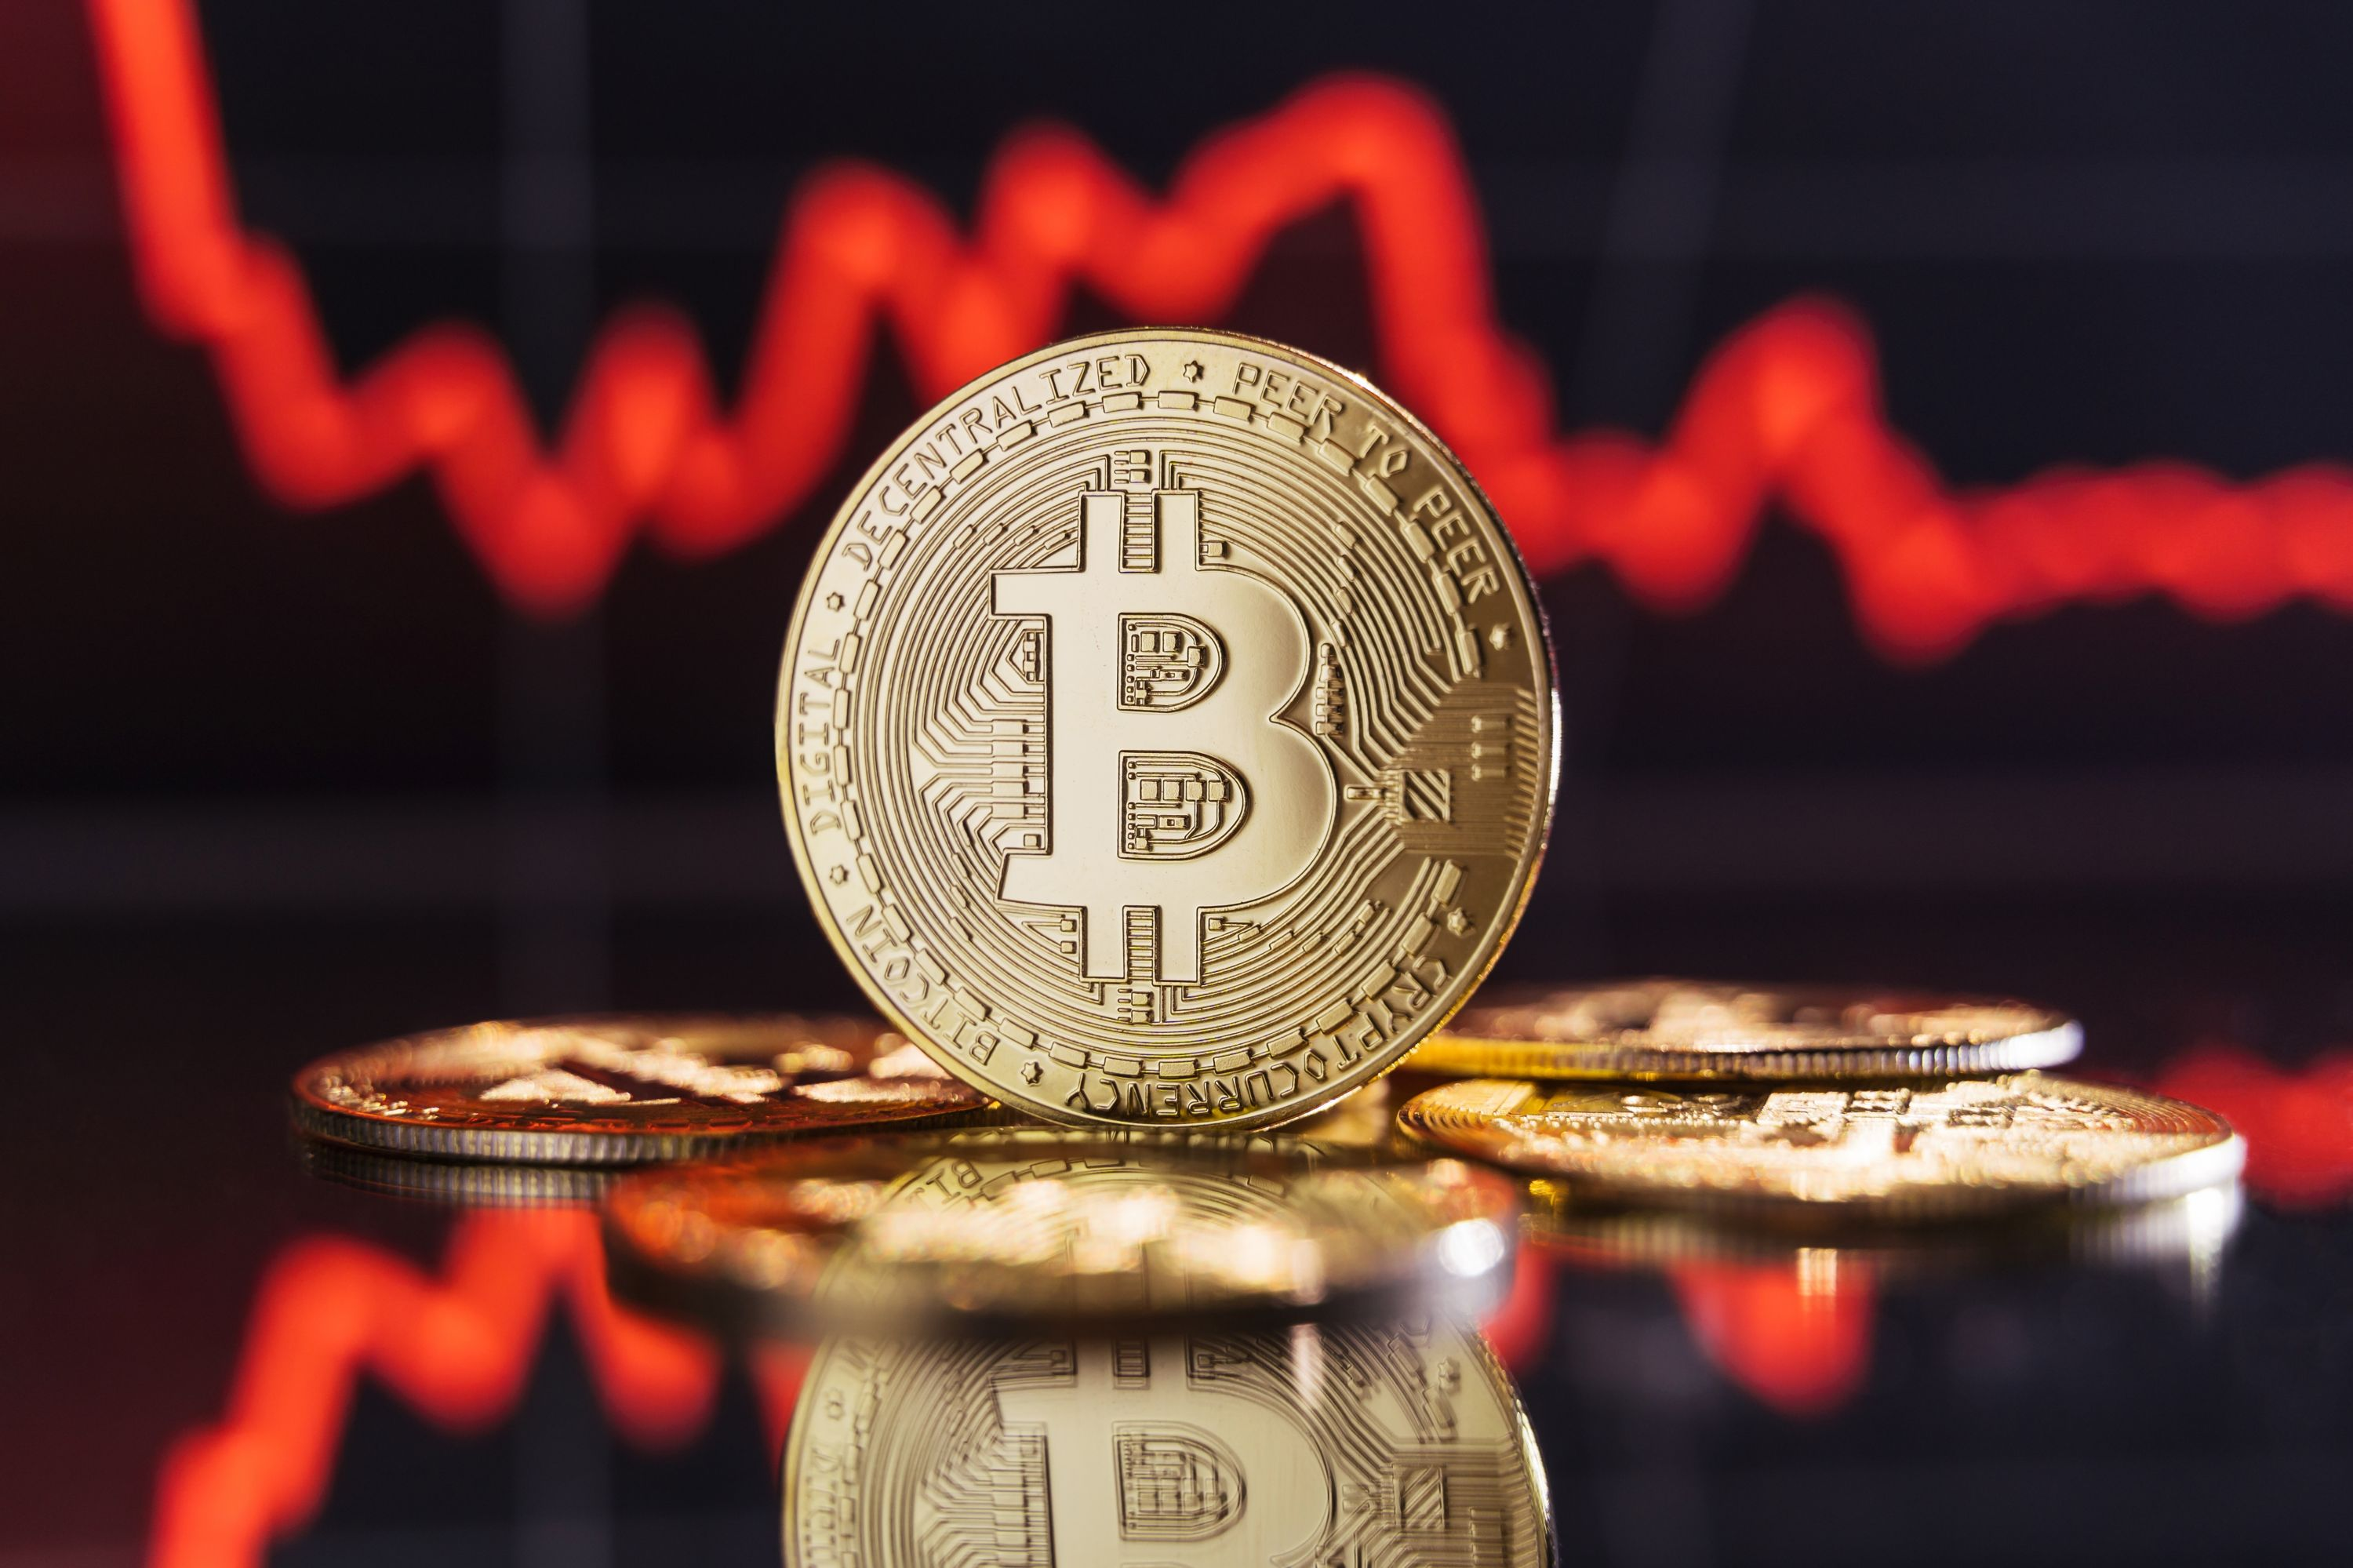

# 1 - Motivación.

Con este proyecto de predicción del precio de cierre del Bitcoin esperamos poder responder las siguientes preguntas:

*   ¿Cómo ha evolucionado el precio de Bitcoin a lo largo del tiempo?
*   ¿Existe una relación entre el volumen de operaciones y la variación del precio?
*   ¿Hay diferencias en el comportamiento del mercado durante diferentes horas del día?
*   ¿Hay días de la semana o meses del año en los que el precio de Bitcoin tiende a ser más volátil o estable?
*   ¿Es posible predecir el precio de cierre del Bicoin diariamente?
*   ¿Existen modelos de predicción que puedan ayudarnos a predecir o ayudar en la toma de decisiones para realizar nuestras inversiones con la criptomoneda?

“Una red consensuada que permite un nuevo sistema de pago y una moneda completamente digital. Es la primera red entre pares de pago descentralizado impulsado por sus usuarios sin una autoridad central o intermediarios”.


# 2 - Audiencia.

Se espera que los resultados obtenidos con este proyecto sean de interes para:

- Entidades públicas y privadas referidas al ambito economico financiero.
- Instituciones educacionales.
- Personas dedicadas a realizar trading de criptomonedas.
- Estudiantes que se estén desarrollando en el ambito de ciencia de datos.

# 3 - Adquisición de la información.

Para este proyecto el dataset que se utilizará son datos actualizados del precio del Bitcoin con datos historicos desde septiembre 2014. Este dataset se obtiene desde la libreria de Yahoo Finance, en el mismo traemos los datos de apertura y cierre del Bitcoin, además de otras variables importantes para nuestro análisis. El dataset nos trae el precio del cierre con intervalo de 1 día.

Variables a utilizar:

1. Date: Hora de apertura de la línea-K en formato de hora Unix.
2. Open: Precio de apertura.
3. High: Precio máximo.
4. Low: Precio mínimo.
5. Close: Precio de cierre.
6. Adj, Close: Precio de cierre ajustado.
7. Volume: Volumen.

# 4 - Dependencias del proyecto.
  - Descripción de los recursos utilizados en este proyecto.

## 4.1 - Librerías

In [ ]:
#@title 4.1.1 - Instalación
!pip install scikit-optimize
!pip install tensorflow
!pip install keras-tuner
!pip install catboost
!pip install ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=327923f36089e402a9c1b19d5a422bbc316932a0dedbbdafca867cfd755abe52
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
#@title 4.1.2 - Importaciones
# ==============================================================================
# Utilidades generales
import os
import math
from datetime import datetime, timedelta

# Manipulación de datos
import pandas as pd
import numpy as np
import ta
import yfinance as yf  # Dataset
import joblib

# Gráficos y visualización
# ==============================================================================
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest, StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.arima.model import ARIMA

# Métricas
# ==============================================================================
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Selección de modelos
# ==============================================================================
from skopt import BayesSearchCV
from skopt.space import Real, Integer


## 4.2 - Paleta de colores
  - Se utilizó la siguiente paleta de colores para los distintos gráficos realizados en este proyeto. Los mismos son los colores utilizados a lo largo de la historia para representar a la criptomoneda: Bitcoin
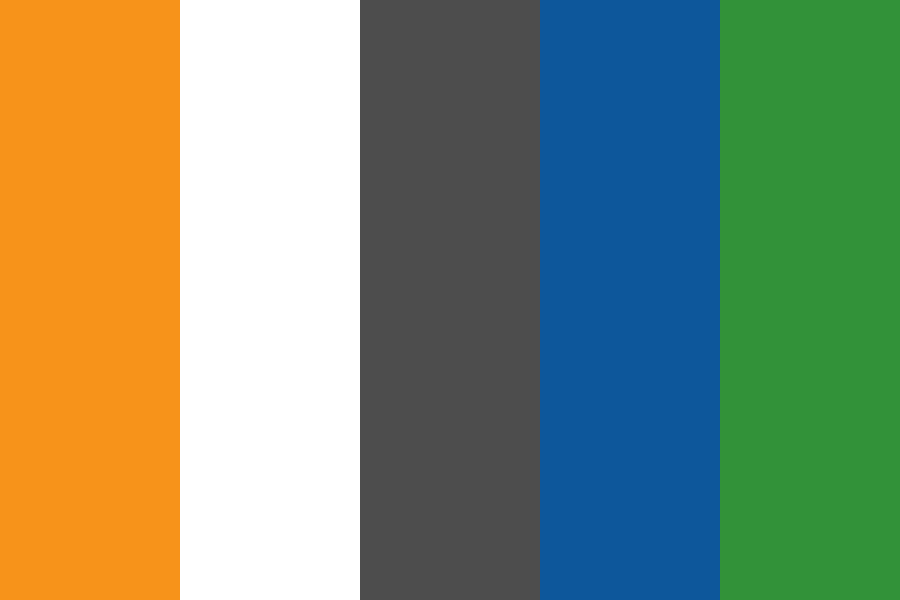

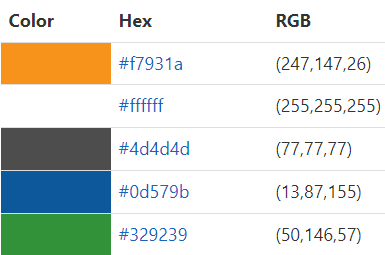

# 5 - EDA (Exploratory Data Analysis).

## 5.1 - Preparación del dataset

In [ ]:
# Se obtienen los datos en tiempo real sobre el Bitcoin utilizando la libreria de Yahoo Finance.
btc_data = yf.Ticker("BTC-USD")

# Se obtiene información del mercado
market_info = btc_data.info
max_supply = 21000000 # Defino el máximo supply que existe de bitcoin (esto lo voy a usar más adelante).

# Se imprimen algunos detalles del mercado de Bitcoin.
print("Bitcoin (BTC) - Detalles del Mercado:")
print("Nombre:", market_info["shortName"])
print("Símbolo:", market_info["symbol"])
print("Capitalización de Mercado:", market_info["marketCap"], 'USD')
print("Suministro Circulante:", market_info["circulatingSupply"] , 'BTC')
print("Suministro máximo:", max_supply , 'BTC')

# Fecha actual.
fecha_actual = datetime.now()

# Se formateo la fecha actual en el formato necesario para la solicitud.
fecha_actual_str = fecha_actual.strftime('%Y-%m-%d')


data_BTC = yf.download(tickers = 'BTC-USD', start = '2014-09-17', end = fecha_actual_str, interval = '1D') # Se define intervalos de 1 día de precio de cierre ya que es el mínimo para el rango que estoy solicitando de 2014
                                                                                                                 # Traigo los precios de cierre desde 2014 hasta la fecha actual.

# Se resetea el índice para que la fecha se convierta en una columna.
data_BTC.reset_index(inplace=True)

# Se imprimen los primeros registros para verificar.
print(data_BTC.head())

Bitcoin (BTC) - Detalles del Mercado:
Nombre: Bitcoin USD
Símbolo: BTC-USD
Capitalización de Mercado: 1220624908288 USD
Suministro Circulante: 19718736 BTC
Suministro máximo: 21000000 BTC


[*********************100%%**********************]  1 of 1 completed

        Date        Open        High         Low       Close   Adj Close  \
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2 2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3 2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4 2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  


In [ ]:
# Se asegura que la columna 'Date' tenga el formato Datetime.
data_BTC.Date = pd.to_datetime(data_BTC.Date)

# Se solicitan los rangos de fecha que contiene el dataset.
fecha_minima = data_BTC['Date'].min()
fecha_maxima = data_BTC['Date'].max()

# Se muestran los rangos de fecha del dataset.
print("Fecha mínima:", fecha_minima)
print("Fecha máxima:", fecha_maxima)

Fecha mínima: 2014-09-17 00:00:00
Fecha máxima: 2024-06-29 00:00:00


In [ ]:
# Se muestran la cantidad de filas del dataframe.
num_filas = data_BTC.shape[0]
print(f"El numero de filas es {num_filas}")

El numero de filas es 3574


In [ ]:
# Se muestran los tipos de datos del dataframe.
data_BTC.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3574 entries, 0 to 3573
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3574 non-null   datetime64[ns]
 1   Open       3574 non-null   float64       
 2   High       3574 non-null   float64       
 3   Low        3574 non-null   float64       
 4   Close      3574 non-null   float64       
 5   Adj Close  3574 non-null   float64       
 6   Volume     3574 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 195.6 KB


In [ ]:
# se revisa la estructura del DataFrame
data_BTC.info()

# Se revisa las primeras filas
data_BTC.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3574 entries, 0 to 3573
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3574 non-null   datetime64[ns]
 1   Open       3574 non-null   float64       
 2   High       3574 non-null   float64       
 3   Low        3574 non-null   float64       
 4   Close      3574 non-null   float64       
 5   Adj Close  3574 non-null   float64       
 6   Volume     3574 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 195.6 KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
# Se muestra las estadísticas descriptivas
tabla_estadisticas = ['Open','High','Low','Close','Volume']
data_BTC[tabla_estadisticas].describe()

,Open,High,Low,Close,Volume
count,3574.000000,3574.000000,3574.000000,3574.000000,3.574000e+03
mean,16847.780621,17233.033958,16436.072123,16863.478308,1.730654e+10
std,18740.779940,19165.882053,18272.799779,18751.089167,1.918445e+10
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,1049.419983,1075.932526,1030.867554,1050.412506,2.487350e+08
50%,8845.115234,9051.989746,8666.731934,8842.057617,1.325379e+10
75%,27719.695312,28189.683105,27213.647461,27741.261719,2.788738e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,3.509679e+11


Este análisis muestra cómo ha cambiado el precio y la cantidad de Bitcoin negociado durante un período de tiempo. Aquí están los puntos clave explicados de una manera sencilla:

1. Precios Promedio:
  - El precio promedio del Bitcoin al inicio del día es de alrededor de $16,811 y al final del día es de $16,826.

2. Variabilidad de Precios:
  - Los precios del Bitcoin han variado mucho, desde tan bajos como $176 hasta tan altos como $73,083. Esta gran variación indica que el precio del Bitcoin puede cambiar de manera muy dramática y rápida.

3. Volumen de Transacciones:
  - La cantidad promedio de Bitcoin negociado diariamente es muy alta, alrededor de 17.3 mil millones de dólares. Sin embargo, este número también varía mucho, con días de muy pocas transacciones y otros con transacciones masivas.

4. Distribución de Precios:
  - La mayoría de los días, los precios están por debajo del promedio, con la mitad de los días (la mediana) viendo precios de alrededor de $8,835. Esto significa que hay algunos días con precios extremadamente altos que elevan el promedio.

En resumen, el mercado del Bitcoin es muy volátil, con precios y volúmenes de transacciones que pueden cambiar significativamente de un día a otro. Esto sugiere que invertir en Bitcoin puede ser riesgoso, ya que su valor puede subir o bajar de manera inesperada.

In [ ]:
# Se eliminam la columna 'Adj Close' del DataFrame ya que no representa un valor para nuestro modelo teniendo valores identico al precio de cierre.
data_BTC = data_BTC.drop('Adj Close', axis=1)

Este código agrega dos nuevas variables que ayudan a entender mejor el comportamiento diario del Bitcoin:

  - Range: Muestra la variación del precio del Bitcoin dentro de un día.
  - Difference: Indica si el precio del Bitcoin subió o bajó durante el día.
Estas nuevas columnas proporcionan información adicional que puede ser útil para analizar la volatilidad y las tendencias diarias del Bitcoin.

#### 5.1.1 - Nueva creación de variables: "Range" y "Difference"

In [ ]:
# Se generan dos columnas nuevas en base a las existentens.
data_BTC['Range'] = data_BTC.High - data_BTC.Low
data_BTC['Difference'] = data_BTC.Close - data_BTC.Open

In [ ]:
# Se muestran los primeros 5 datos del dataset con la columna 'Adj Close' eliminada y las nuevas columnas Range y Difference.
data_BTC.head()

,Date,Open,High,Low,Close,Volume,Range,Difference
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,15.752014,-8.529999
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,43.755981,-32.419983
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,43.302979,-29.307007
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,33.412994,14.230988
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,19.244995,-9.263977


In [ ]:
# Se realiza un describe para mostrar el valor medio, la desviación estándar, el valor mínimo, máximo, la mediana y los valores correspondientes a los percentiles 25% y 75%.
# Se selecciona las columnas específicas que quiero describir
tabla_estadisticas = ['Open', 'High', 'Low', 'Close', 'Volume', 'Range', 'Difference']

# Se realiza el describe de las columnas seleccionadas
data_BTC[tabla_estadisticas].describe()

,Open,High,Low,Close,Volume,Range,Difference
count,3574.000000,3574.000000,3574.000000,3574.000000,3.574000e+03,3574.000000,3574.000000
mean,16847.780621,17233.033958,16436.072123,16863.478308,1.730654e+10,796.961835,15.697687
std,18740.779940,19165.882053,18272.799779,18751.089167,1.918445e+10,1199.907375,858.330850
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,1.028000,-7563.996094
25%,1049.419983,1075.932526,1030.867554,1050.412506,2.487350e+08,41.518234,-97.865234
50%,8845.115234,9051.989746,8666.731934,8842.057617,1.325379e+10,316.850342,1.444984
75%,27719.695312,28189.683105,27213.647461,27741.261719,2.788738e+10,1033.465820,123.489502
max,73079.375000,73750.070312,71334.093750,73083.500000,3.509679e+11,12864.621094,7309.636719


Las nuevas columnas "Range" y "Difference" proporcionan información valiosa sobre la volatilidad diaria del Bitcoin:

  - Range: Muestra cuánto varía el precio del Bitcoin dentro de un día. En promedio, el precio varía en 796.33, pero puede ser tan bajo como 1.03 o tan alto como 12864.62.
  - Difference: Indica el cambio neto en el precio del Bitcoin desde la apertura hasta el cierre del día. En promedio, el precio cambia ligeramente, pero puede aumentar hasta 7309.64 o disminuir hasta 7564.00 en un solo día.

Estos datos subrayan la naturaleza volátil del mercado del Bitcoin, lo que es importante considerar para inversores y analistas.

In [ ]:
# Se analiza si existen filas duplicadas.
data_BTC.duplicated().sum()

0

In [ ]:
# Se verifica y analiza datos ausentes (en este caso no hay datos ausentes)
valores_ausentes = data_BTC.isnull().sum()
porcentajes_ausentes = valores_ausentes / len(data_BTC) * 100

print("Valores ausentes por columna:")
print(valores_ausentes)

print("Porcentaje de valores ausentes por columna:")
print(porcentajes_ausentes)

Valores ausentes por columna:
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Range         0
Difference    0
dtype: int64
Porcentaje de valores ausentes por columna:
Date          0.0
Open          0.0
High          0.0
Low           0.0
Close         0.0
Volume        0.0
Range         0.0
Difference    0.0
dtype: float64


In [ ]:
# Se ordena por la variable tiempo de manera ascendente.
data_BTC = data_BTC.sort_values(by='Date')

## 5.2 - Análisis Gráficos.




In [ ]:
# Se generan nuevas columnas para MES y AÑO.
data_BTC['Date'] = pd.to_datetime(data_BTC['Date'])
data_BTC['Month'] = data_BTC['Date'].dt.month
data_BTC['Year'] = data_BTC['Date'].dt.year

In [ ]:
# Se realiza un describe del dataframe
data_BTC.describe()

,Date,Open,High,Low,Close,Volume,Range,Difference,Month,Year
count,3574,3574.000000,3574.000000,3574.000000,3574.000000,3.574000e+03,3574.000000,3574.000000,3574.000000,3574.000000
mean,2019-08-08 12:00:00,16847.780621,17233.033958,16436.072123,16863.478308,1.730654e+10,796.961835,15.697687,6.494404,2019.104365
min,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,5.914570e+06,1.028000,-7563.996094,1.000000,2014.000000
25%,2017-02-26 06:00:00,1049.419983,1075.932526,1030.867554,1050.412506,2.487350e+08,41.518234,-97.865234,3.000000,2017.000000
50%,2019-08-08 12:00:00,8845.115234,9051.989746,8666.731934,8842.057617,1.325379e+10,316.850342,1.444984,6.000000,2019.000000
75%,2022-01-17 18:00:00,27719.695312,28189.683105,27213.647461,27741.261719,2.788738e+10,1033.465820,123.489502,10.000000,2022.000000
max,2024-06-29 00:00:00,73079.375000,73750.070312,71334.093750,73083.500000,3.509679e+11,12864.621094,7309.636719,12.000000,2024.000000
std,NaN,18740.779940,19165.882053,18272.799779,18751.089167,1.918445e+10,1199.907375,858.330850,3.480198,2.851197


In [ ]:
# Se establece el estilo de seaborn.
sns.set_style("whitegrid", {"grid.color": ".8"})

### 5.2.1 - HEATMAP

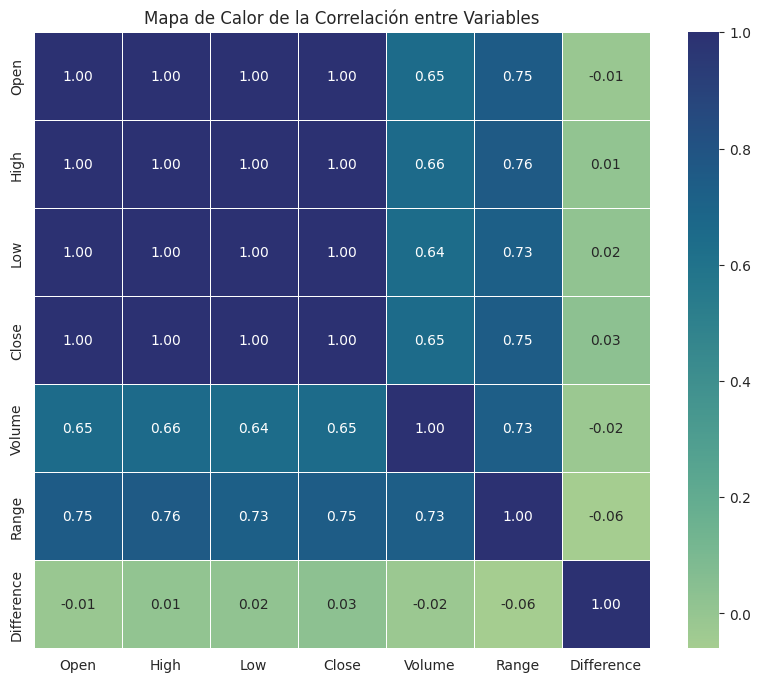

In [ ]:
# Se grafica los coeficientes de correlacion entre las variables en un heatmap.
# Se calcula la matriz de correlación.
matriz_correlacion = data_BTC[['Open', 'High', 'Low', 'Close', 'Volume', 'Range', 'Difference']].corr()

# Se crea el heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='crest', square=True, linewidths=.5)

# Título del heatmap.
plt.title('Mapa de Calor de la Correlación entre Variables')

# Se muestra el gráfico.
plt.show()

In [ ]:
# Dataframe del Heatmap creado.
matriz_correlacion.head(7)

,Open,High,Low,Close,Volume,Range,Difference
Open,1.000000,0.999540,0.999228,0.998952,0.650092,0.748694,-0.010886
High,0.999540,1.000000,0.999083,0.999546,0.655856,0.758255,0.012144
Low,0.999228,0.999083,1.000000,0.999442,0.639862,0.729648,0.016668
Close,0.998952,0.999546,0.999442,1.000000,0.648848,0.745542,0.034895
Volume,0.650092,0.655856,0.639862,0.648848,1.000000,0.731718,-0.019355
Range,0.748694,0.758255,0.729648,0.745542,0.731718,1.000000,-0.059865
Difference,-0.010886,0.012144,0.016668,0.034895,-0.019355,-0.059865,1.000000


#### 5.2.1.1 - Análisis de resultados:

1. Altas Correlaciones Positivas:
  - Open, High, Low, Close: Estas cuatro variables están altamente correlacionadas entre sí, con coeficientes de correlación cercanos a 1. Esto indica que cuando una de estas variables sube o baja, las otras tienden a moverse en la misma dirección.
  - Range y Volume: El rango diario (Range) y el volumen de transacciones (Volume) también muestran una correlación positiva moderada (0.732), indicando que días con mayor variación en los precios tienden a tener un mayor volumen de transacciones.

2. Bajas Correlaciones:
  - Difference: La diferencia diaria entre el precio de cierre y el de apertura (Difference) tiene una baja correlación con las demás variables. Esto sugiere que el cambio neto diario del precio no está fuertemente influenciado por los precios de apertura, cierre, máximo, mínimo, o el volumen de transacciones.

3. Insight Adicional:
  - Range: El rango diario está moderadamente correlacionado con todas las variables de precio (Open, High, Low, Close), lo que es esperado ya que estas variables determinan el rango.

Conclusión:
El heatmap de correlación revela fuertes relaciones entre los precios de apertura, máximo, mínimo y cierre del Bitcoin. Sin embargo, la diferencia diaria del precio tiene poca correlación con estas variables, destacando que las variaciones diarias en los precios de apertura y cierre no están directamente relacionadas con el comportamiento diario general del mercado. Esta información puede ser útil para entender la dinámica del mercado del Bitcoin y para desarrollar estrategias de inversión y análisis.

### 5.2.2 - BOXPLOT

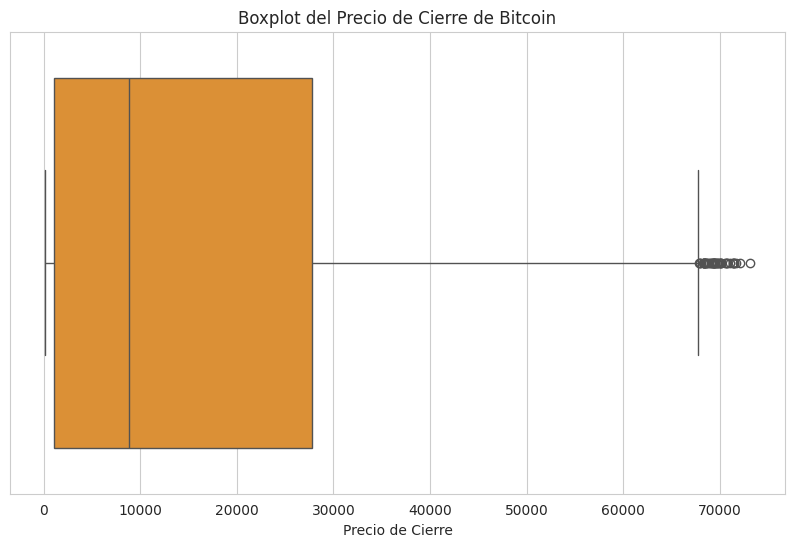

           Date          Open          High           Low         Close  \
3456 2024-03-04  63137.003906  68537.031250  62386.519531  68330.414062   
3460 2024-03-08  66938.093750  70083.054688  66230.453125  68300.093750   
3461 2024-03-09  68299.257812  68673.054688  68053.125000  68498.882812   
3462 2024-03-10  68500.257812  70005.203125  68239.976562  69019.789062   
3463 2024-03-11  69020.546875  72850.710938  67194.882812  72123.906250   
3464 2024-03-12  72125.125000  72825.656250  68728.851562  71481.289062   
3465 2024-03-13  71482.117188  73637.476562  71334.093750  73083.500000   
3466 2024-03-14  73079.375000  73750.070312  68563.023438  71396.593750   
3467 2024-03-15  71387.875000  72357.132812  65630.695312  69403.773438   
3469 2024-03-17  65316.343750  68845.718750  64545.316406  68390.625000   
3472 2024-03-20  61930.156250  68115.257812  60807.785156  67913.671875   
3477 2024-03-25  67234.093750  71162.593750  66414.835938  69958.812500   
3478 2024-03-26  69931.32

In [ ]:
# Se crea el boxplot.
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_BTC['Close'], color= "#f7931a")

# Título y etiquetas.
plt.title('Boxplot del Precio de Cierre de Bitcoin')
plt.xlabel('Precio de Cierre')

# Se muestra el gráfico.
plt.show()
#-----------------------------------------------------
#Analisis númerico

# Se identifican los outliers utilizando el IQR.
Q1 = data_BTC['Close'].quantile(0.25)
Q3 = data_BTC['Close'].quantile(0.75)
IQR = Q3 - Q1

# Se define los límites para los outliers.
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR

# Se filtran los outliers.
outliers = data_BTC[(data_BTC['Close'] < lim_inf) | (data_BTC['Close'] > lim_sup)]

# Se crea un dataframe con los outliers.
outliers_df = outliers.copy()

# Se muestran los outliers.
print(outliers_df)

# Se cuentan el número de outliers.
num_outliers = len(outliers_df)

# Se muestra la cantidad de outliers.
print(f'Cantidad de outliers: {num_outliers}')

#### 5.2.2.1 - Análisis de resultados:
  - Boxplot: El boxplot proporciona una visualización clara de la distribución del precio de cierre del Bitcoin, mostrando la mediana, los cuartiles, y los posibles outliers.
  - Outliers: Se identificaron 48 outliers en los datos del precio de cierre del Bitcoin, que son valores significativamente más altos o más bajos que la mayoría de los datos.

Conclusión:
El boxplot y el análisis de outliers son herramientas útiles para comprender la distribución de los precios de cierre del Bitcoin y para identificar valores que son anormalmente altos o bajos. Estos outliers pueden ser días con movimientos de precios extremos que pueden ser de interés para un análisis más detallado.

## 5.3 - Análisis temporal.

### 5.3.1 - Descomposición Estacional:

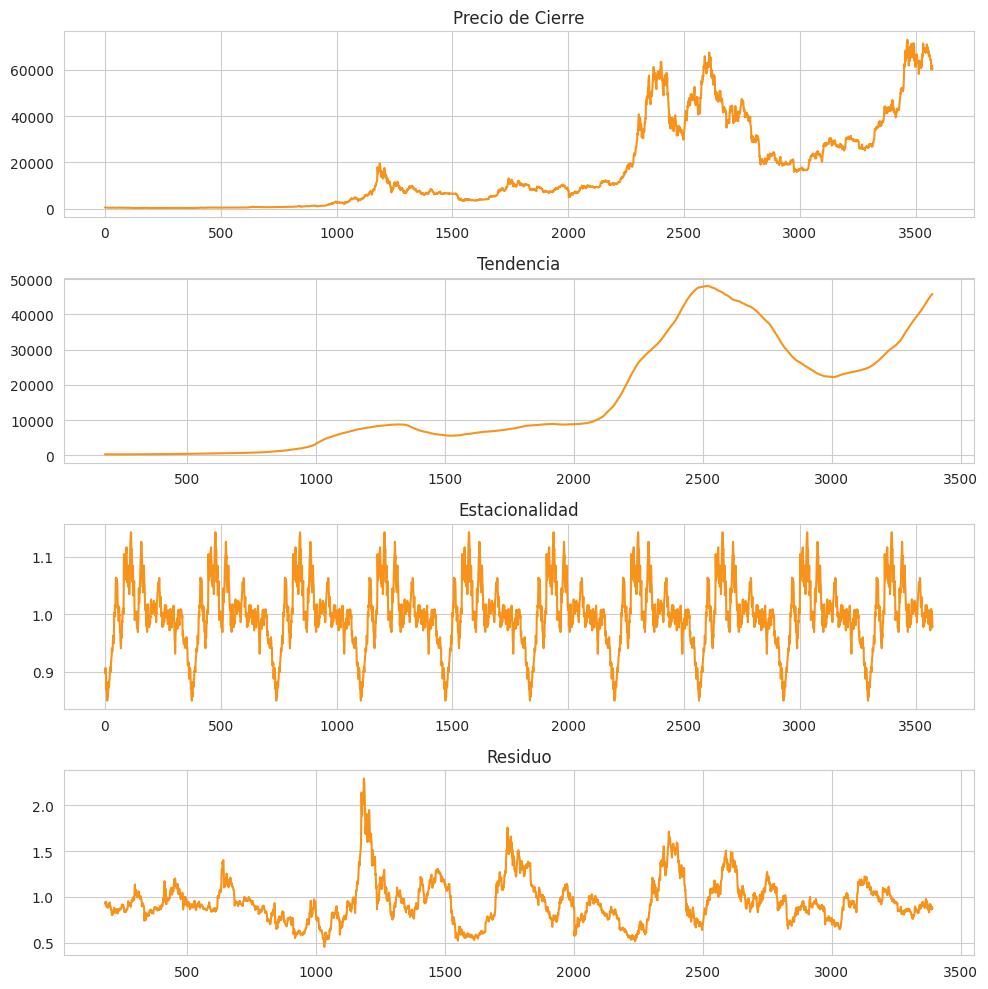

In [ ]:
# Se descompone la serie temporal en tendencia, estacionalidad y componente residual
resultadps = seasonal_decompose(data_BTC['Close'], model='multiplicative', period=365)

# Visualización de la Tendencia y Estacionalidad
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 10))
data_BTC['Close'].plot(ax=ax0, title='Precio de Cierre', color='#f7931a')
resultadps.trend.plot(ax=ax1, title='Tendencia',color='#f7931a')
resultadps.seasonal.plot(ax=ax2, title='Estacionalidad',color='#f7931a')
resultadps.resid.plot(ax=ax3, title='Residuo',color='#f7931a')
plt.tight_layout()
plt.show()

#### 5.3.1.1 - Análisis del gráfico de Descomposición Estacional:

El gráfico resultante muestra cuatro subgráficos:

1.Serie Original (Close):
  - Este subgráfico muestra el precio de cierre del Bitcoin a lo largo del tiempo. Se puede observar la tendencia general de aumento con algunas fluctuaciones significativas.

2.Tendencia (Trend):
  - La tendencia muestra la dirección general del precio del Bitcoin. En el gráfico, se puede observar una tendencia al alza con algunas fases de declive, reflejando los movimientos de largo plazo en el precio del Bitcoin.

3.Estacionalidad (Seasonal):
  - La componente estacional muestra patrones repetitivos a lo largo del tiempo. En este caso, el gráfico de estacionalidad revela fluctuaciones periódicas que se repiten anualmente, indicando que hay ciertos momentos del año donde los precios tienden a ser más altos o más bajos.

4.Residuos (Resid):
  - Los residuos representan las variaciones que no pueden ser explicadas por la tendencia ni por la estacionalidad. En el gráfico, se observa que los residuos son relativamente constantes pero muestran algunos picos, indicando días con movimientos de precios inusuales.

Conclusión:
La descomposición de la serie temporal del precio de cierre del Bitcoin permite identificar tres componentes clave:

  - Tendencia: Muestra un aumento general en el precio del Bitcoin con algunas fluctuaciones.
  - Estacionalidad: Revela patrones repetitivos anuales en los precios del Bitcoin.
  - Residuos: Indica variaciones no explicadas por la tendencia ni la estacionalidad, reflejando eventos inusuales o movimientos de precios abruptos.

Esta descomposición ayuda a entender mejor las características del precio del Bitcoin y puede ser útil para realizar análisis predictivos y tomar decisiones informadas de inversión.

### 5.3.2 - Análisis de Autocorrelación:

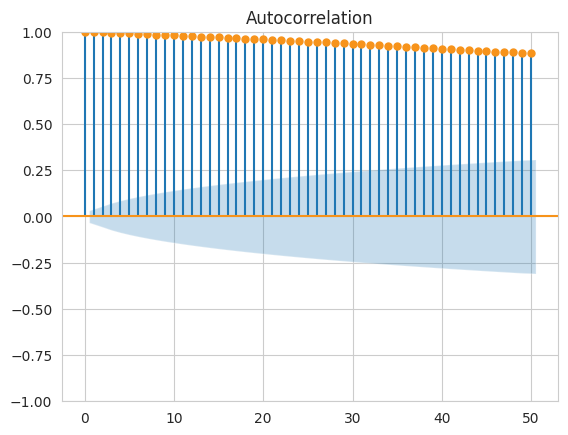

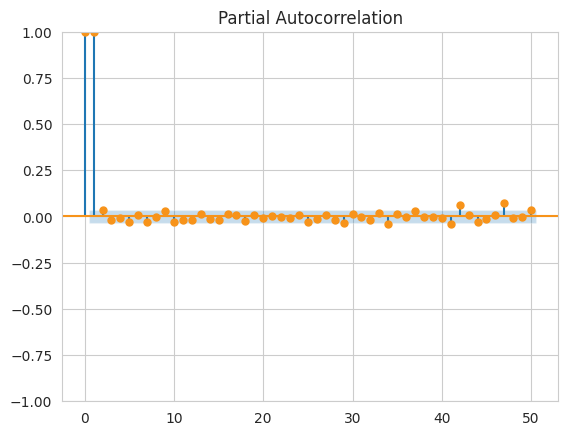

In [ ]:
# Se utilizan gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar la dependencia temporal en los datos.
plot_acf(data_BTC['Close'], lags=50, color= "#f7931a")
plot_pacf(data_BTC['Close'], lags=50, color= "#f7931a")
plt.show()

#### 5.3.2.1 - Análisis del gráfico de Autocorrelación (ACF)
El gráfico de autocorrelación muestra cómo los valores del precio de cierre del Bitcoin están correlacionados con sus valores en diferentes retardos (lags).

- Autocorrelaciones Altas:

  - Se observa una autocorrelación alta en los primeros retardos, lo que indica que los valores de cierre del Bitcoin están fuertemente correlacionados con sus valores recientes.
  - Esta alta autocorrelación disminuye gradualmente, lo que sugiere que la dependencia temporal se reduce con el tiempo.

- Patrón de Disminución:
  - La disminución gradual en las autocorrelaciones sugiere una memoria larga en la serie temporal, indicando que los precios de cierre pasados siguen influyendo en los precios actuales, aunque con menor intensidad a medida que aumenta el retardo.

- Intervalo de Confianza:
  - Las líneas sombreadas en azul representan el intervalo de confianza. Los puntos que caen fuera de este intervalo son significativos y sugieren una autocorrelación significativa.

Conclusión:
El análisis de autocorrelación revela que el precio de cierre del Bitcoin tiene una fuerte dependencia temporal en los primeros retardos. Esta dependencia disminuye gradualmente, indicando que los precios pasados del Bitcoin siguen teniendo una influencia en los precios actuales, aunque esta influencia se debilita con el tiempo. Este patrón es común en series temporales financieras y sugiere que los modelos predictivos deberían considerar la dependencia de los valores pasados para mejorar la precisión de las predicciones.

## 5.4 - Análisis por Hora Día de la Semana.


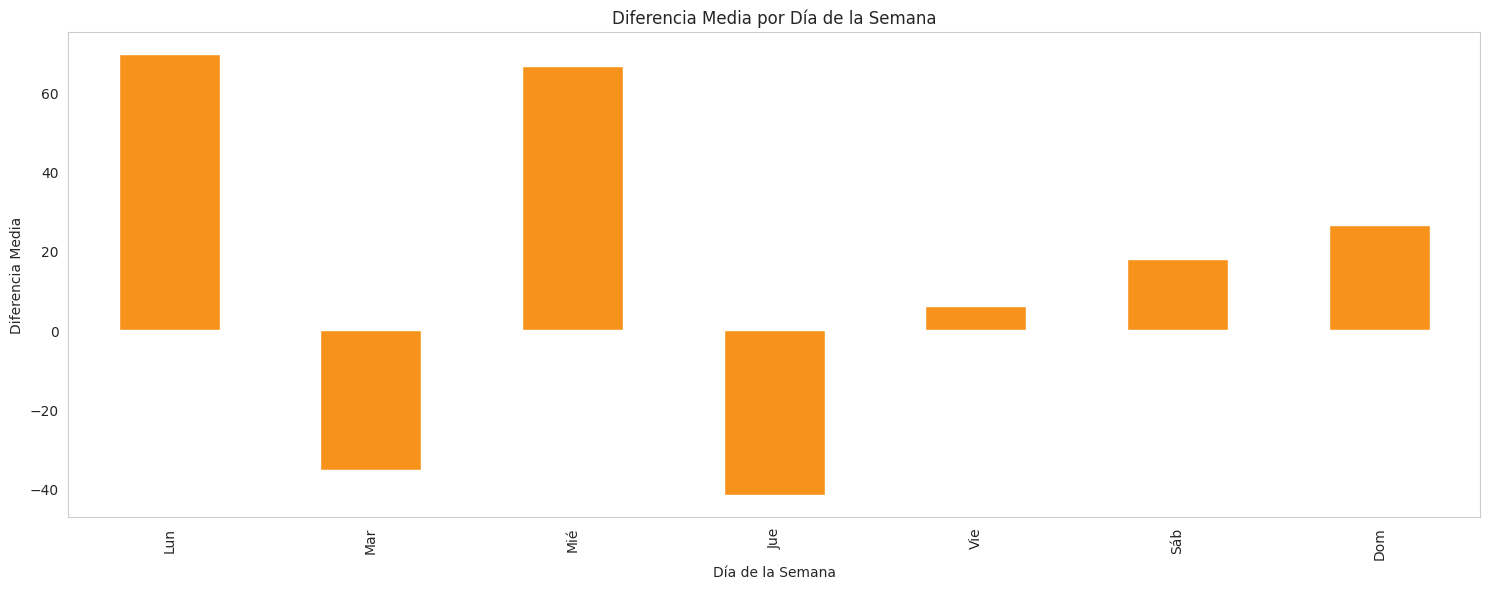

In [ ]:
# Se añade columna de día de la semana
data_BTC['DayOfWeek'] = data_BTC['Date'].dt.day_name()

# Se calcula la diferencia media por día de la semana
dif_prom_diaria = data_BTC.groupby(data_BTC['Date'].dt.weekday)['Difference'].mean()


# Se crea gráfico de barras
fig, axs = plt.subplots(1, figsize=(15, 6))

dif_prom_diaria.plot(kind='bar', ax=axs, color='#f7931a')
axs.set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
axs.set_title('Diferencia Media por Día de la Semana')
axs.set_xlabel('Día de la Semana')
axs.set_ylabel('Diferencia Media')
axs.grid()

plt.tight_layout()
plt.show()

##### 5.4.1 - Análisis del resultado:
El análisis revela patrones interesantes en la diferencia media del precio de apertura y cierre del Bitcoin según el día de la semana:

  - Días con Diferencia Positiva Alta: Lunes y miércoles son los días con las mayores diferencias medias positivas, indicando una tendencia a que los precios de cierre sean significativamente más altos que los precios de apertura.
  - Días con Diferencia Negativa: Martes y jueves muestran diferencias medias negativas, sugiriendo que los precios de cierre tienden a ser más bajos que los de apertura en estos días.
  - Fines de Semana y Viernes: Los viernes, sábados y domingos tienen diferencias medias positivas pero menores, indicando una menor variabilidad en comparación con los lunes y miércoles.

Estos patrones pueden ser útiles para traders e inversores al considerar estrategias basadas en el comportamiento histórico del mercado del Bitcoin en diferentes días de la semana.

## 5.5 - Análisis de Volatilidad.

### 5.5.1 - Volatilidad Mensual:

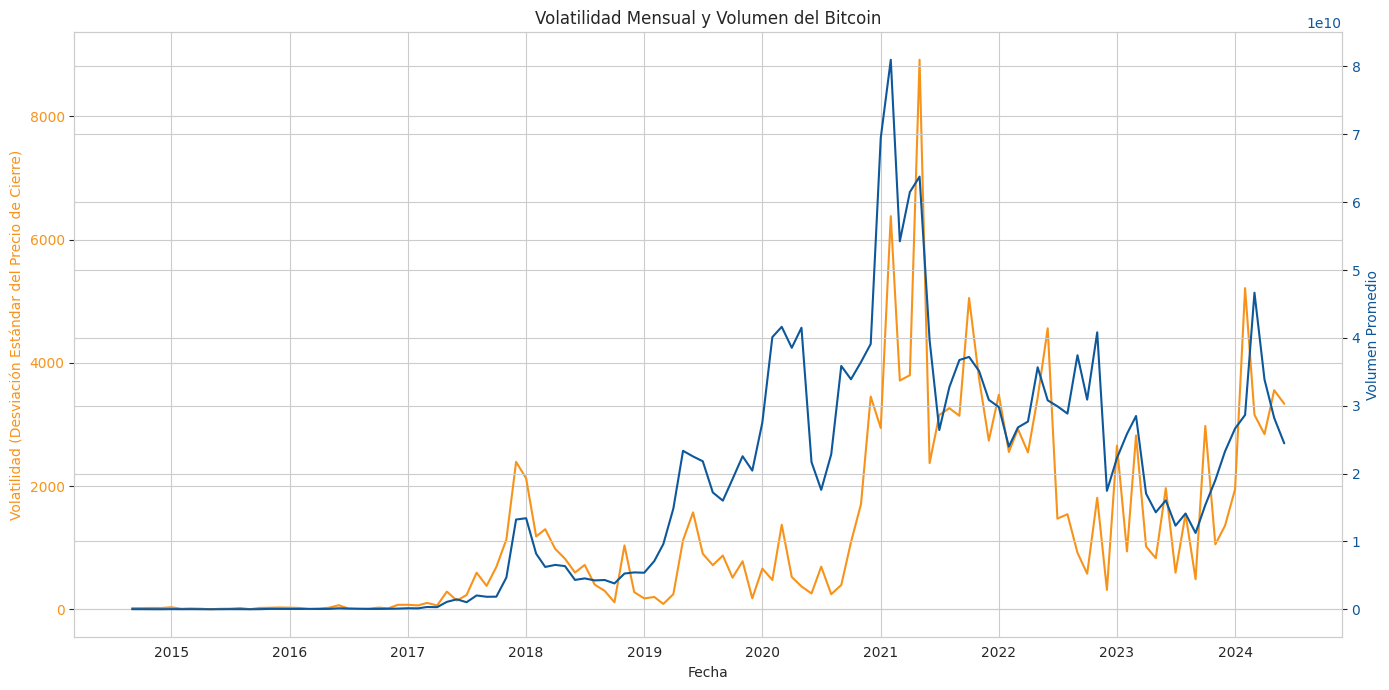

In [ ]:
# Se agrupa por año y mes, y calcular la desviación estándar del precio de cierre y el volumen promedio
estadisticas_mensuales = data_BTC.groupby(['Year', 'Month']).agg({'Close': 'std', 'Volume': 'mean'}).reset_index()
estadisticas_mensuales['Date'] = pd.to_datetime(estadisticas_mensuales[['Year', 'Month']].assign(DAY=1))

# Se grafica la volatilidad mensual y el volumen
fig, ax1 = plt.subplots(figsize=(14, 7))

# Se grafica la volatilidad en el eje y izquierdo
ax1.plot(estadisticas_mensuales['Date'], estadisticas_mensuales['Close'], color='#f7931a', label='Volatilidad (Desviación Estándar)')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Volatilidad (Desviación Estándar del Precio de Cierre)', color='#f7931a')
ax1.tick_params(axis='y', labelcolor='#f7931a')

# Se crea un segundo eje y para el volumen
ax2 = ax1.twinx()
ax2.plot(estadisticas_mensuales['Date'], estadisticas_mensuales['Volume'], color='#0d579b', label='Volumen')
ax2.set_ylabel('Volumen Promedio', color='#0d579b')
ax2.tick_params(axis='y', labelcolor='#0d579b')

# Título y leyendas
plt.title('Volatilidad Mensual y Volumen del Bitcoin')
fig.tight_layout()

# Se muestra el gráfico
plt.show()

#### 5.5.1.1 - Análisis del gráfico:
El gráfico muestra la relación entre la volatilidad mensual del precio de cierre del Bitcoin y el volumen mensual de transacciones desde 2015 hasta 2024.

1. Relación Entre Volatilidad y Volumen:

  - En general, los picos de volatilidad (línea naranja) parecen coincidir con los picos de volumen de transacciones (línea azul), especialmente en períodos de alta inestabilidad del mercado, como alrededor de 2018 y 2021.
  - Esto sugiere que los períodos de mayor volatilidad en los precios del Bitcoin tienden a estar acompañados por un mayor volumen de transacciones, lo que podría indicar una mayor actividad de trading y cambios en la percepción del mercado.

2. Picos de Volatilidad y Volumen:
  - Los picos de volatilidad más altos se observan a finales de 2017 y principios de 2021, coincidiendo con picos significativos en el volumen de transacciones.
  - Durante estos períodos, el mercado del Bitcoin experimentó movimientos de precios extremos y un alto nivel de actividad de transacciones, lo que puede reflejar eventos significativos o cambios en el sentimiento del mercado.

3. Tendencias Recientes:
  - En los años más recientes, la volatilidad y el volumen continúan mostrando variaciones significativas, aunque con patrones menos extremos comparados con los picos históricos.

Conclusión:
El análisis conjunto de la volatilidad mensual del precio de cierre del Bitcoin y el volumen mensual de transacciones proporciona una visión clara de cómo estos dos factores están relacionados. Los períodos de alta volatilidad tienden a coincidir con un aumento en el volumen de transacciones, lo que puede indicar una mayor actividad y fluctuaciones en el mercado.

Esta información es valiosa para inversores y traders que buscan entender mejor la dinámica del mercado del Bitcoin y tomar decisiones informadas basadas en la volatilidad y el volumen de transacciones.

### 5.5.2 - Heatmap de la volatilidad mensual:

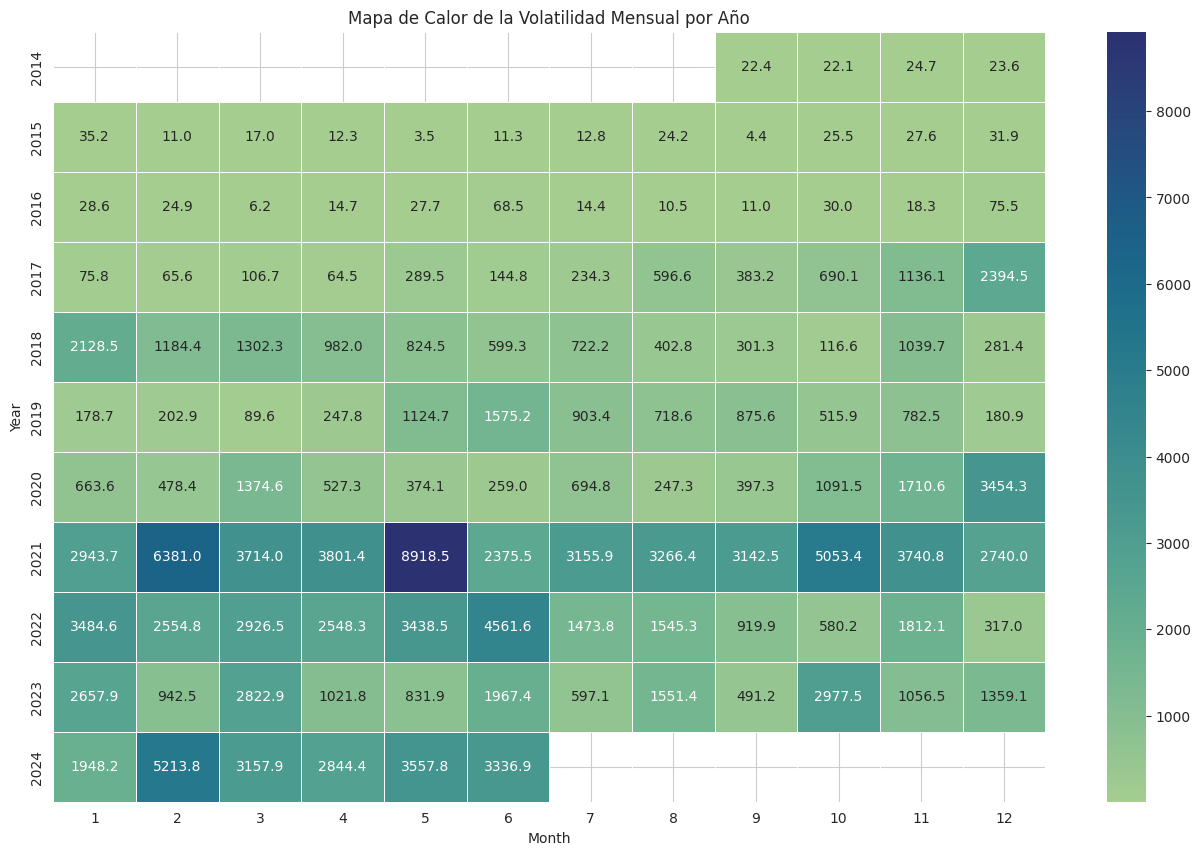

In [ ]:
# Se identifican patrones estacionales dentro de los datos del Bitcoin para descubrir si ciertos períodos del año tienden a ser más volátiles.
# Se agrupa y analiza la volatilidad mensual promedio por año
volatilidad_mensual = data_BTC.groupby(['Year', 'Month'])['Close'].std().unstack()


# Se configura el tamaño de la figura
plt.figure(figsize=(16, 10))  # Ajusta el tamaño a tu preferencia

# Se crea el heatmap
sns.heatmap(volatilidad_mensual, annot=True, fmt=".1f", cmap='crest', linewidths=.5)

# Se configura el título
plt.title('Mapa de Calor de la Volatilidad Mensual por Año')

# Se muestra el gráfico
plt.show()

#### 5.5.2.1 - Análisis del Gráfico:
El gráfico muestra la volatilidad mensual del precio de cierre del Bitcoin para cada mes y año, desde 2014 hasta 2024. La volatilidad se mide mediante la desviación estándar del precio de cierre.

1. Patrones de Volatilidad Alta:

  - La mayor volatilidad se observa en varios picos a lo largo de los años. En particular, se destacan los valores extremadamente altos en junio de 2021 (8918.5) y febrero de 2024 (5213.8).
  - Estos picos indican meses donde los precios del Bitcoin experimentaron grandes fluctuaciones.

2. Años con Alta Volatilidad:
  - El año 2021 muestra varios meses con alta volatilidad, especialmente en la primera mitad del año.
  - Otros años como 2018, 2020 y 2022 también muestran meses con alta volatilidad, aunque no tan extrema como en 2021.

3. Estacionalidad:
  - No hay un patrón claro de estacionalidad en la volatilidad mensual del Bitcoin. Los meses de alta volatilidad parecen distribuidos a lo largo de diferentes años sin un patrón consistente en meses específicos.

4. Tendencias Recientes:
  - En los últimos años, se observa una variabilidad significativa en la volatilidad mensual, indicando períodos continuos de inestabilidad en el mercado del Bitcoin.

Conclusión:
El mapa de calor de la volatilidad mensual por año revela que la volatilidad del precio de cierre del Bitcoin no sigue un patrón estacional claro y está sujeta a variaciones significativas en diferentes meses y años. Los picos de volatilidad en ciertos meses reflejan períodos de alta inestabilidad en el mercado, lo que puede estar relacionado con eventos específicos del mercado o cambios en el sentimiento de los inversores.

Esta información es valiosa para los inversores y analistas que buscan entender mejor la naturaleza volátil del mercado del Bitcoin y tomar decisiones informadas basadas en la volatilidad histórica.

## 5.6 Análisis de Distribución.

#### 5.6.1 - Histograma y KDE:

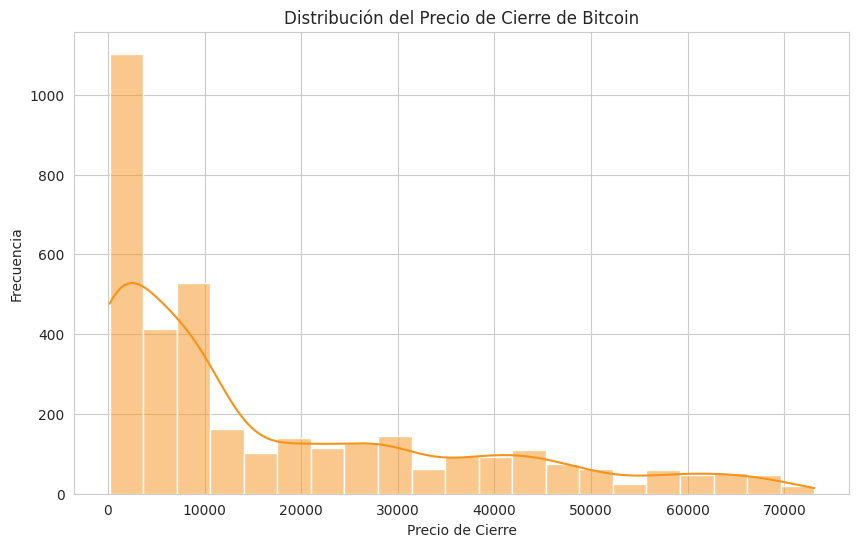

In [ ]:
# Se visualiza la distribución del precio de cierre con histogramas y gráficos de densidad.
plt.figure(figsize=(10, 6))
sns.histplot(data_BTC['Close'], kde=True, color="#f7931a")
plt.title('Distribución del Precio de Cierre de Bitcoin')
plt.xlabel('Precio de Cierre')
plt.ylabel('Frecuencia')
plt.show()

##### 5.6.1.1 - Análisis del Gráfico:
El gráfico combina un histograma y una línea KDE para mostrar la distribución del precio de cierre del Bitcoin a lo largo del tiempo.

1. Distribución Sesgada a la Derecha:
  - La distribución del precio de cierre del Bitcoin está claramente sesgada a la derecha, con una gran concentración de frecuencias en los precios más bajos y una cola que se extiende hacia precios más altos.
  - Esto indica que, aunque ha habido días con precios de cierre muy altos, la mayoría de los precios de cierre del Bitcoin han sido relativamente bajos.

2. Modos Múltiples:
  - La línea KDE muestra varios picos o modos, lo que sugiere la presencia de múltiples sub-distribuciones dentro de los datos. Esto puede reflejar diferentes fases en la historia del Bitcoin, como períodos de crecimiento rápido o caídas significativas.

3. Rangos de Precios:
  - La mayor frecuencia de precios de cierre se encuentra en el rango de $0 a $10,000, con un número decreciente de ocurrencias a medida que el precio aumenta.
  - Hay algunos picos menores en los rangos de $10,000 a $30,000 y $30,000 a $50,000, indicando que estos rangos de precios también han sido comunes en la historia del Bitcoin.

Conclusión:
El histograma y la línea KDE proporcionan una visualización clara de la distribución del precio de cierre del Bitcoin. La distribución está sesgada a la derecha, con la mayoría de los precios de cierre en los rangos más bajos, pero con algunos picos que indican períodos de precios más altos. La presencia de múltiples modos sugiere diferentes fases en la evolución del precio del Bitcoin.

Esta visualización es útil para entender la frecuencia y la densidad de los precios de cierre del Bitcoin, proporcionando una base para análisis más detallados sobre las tendencias y patrones en el mercado del Bitcoin.

#### 5.6.2 - Boxplot por Mes:

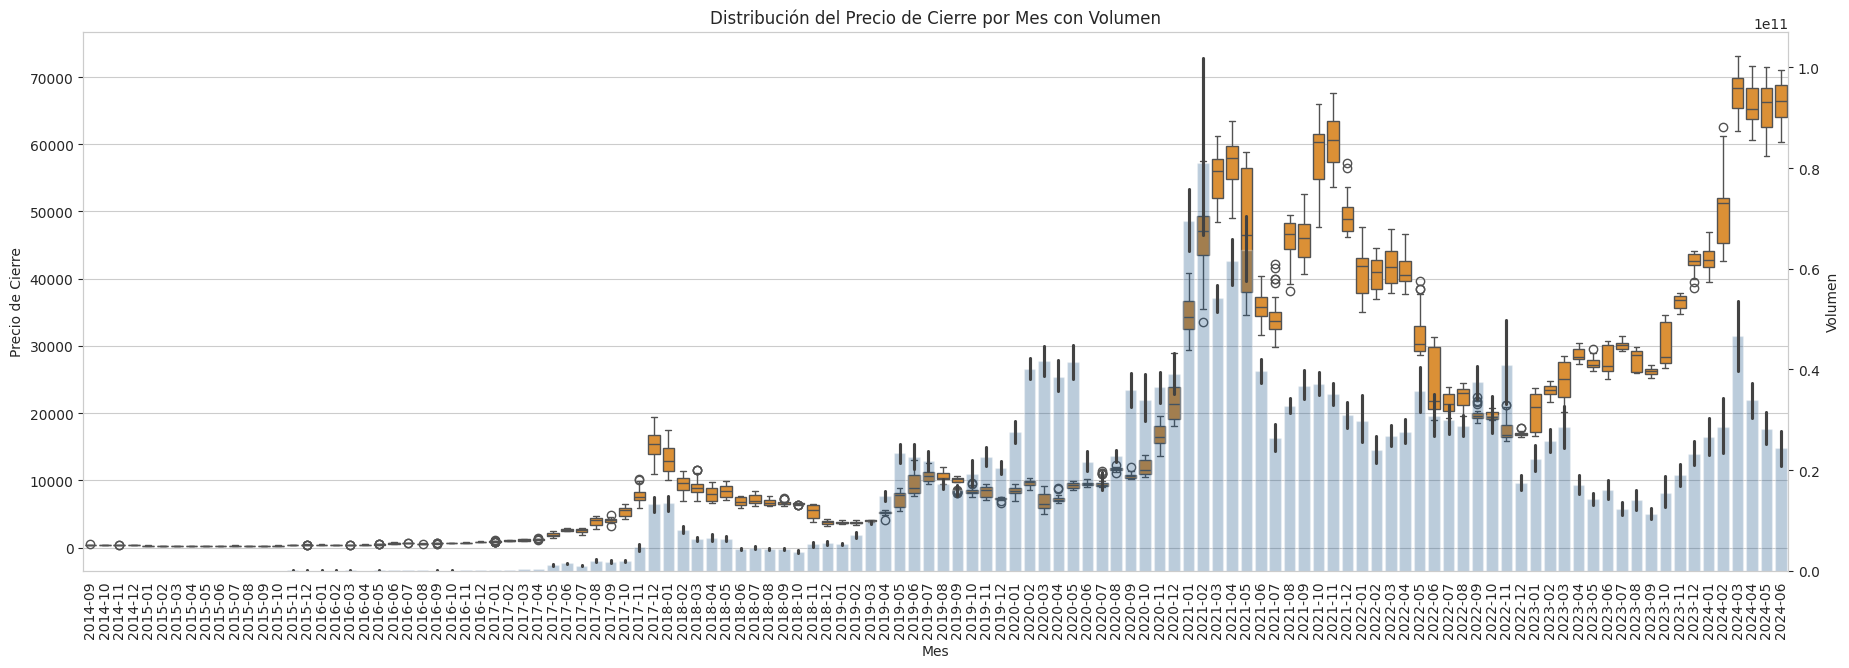

In [ ]:
# Se asegura de tener la columna 'YearMonth' en el DataFrame
data_BTC['YearMonth'] = data_BTC['Date'].dt.to_period('M')

# Se configura la figura y el eje secundario
fig, ax1 = plt.subplots(figsize=(22, 7))

# Gráfico de caja para la distribución del precio de cierre
sns.boxplot(data=data_BTC, x='YearMonth', y='Close', color="#f7931a", ax=ax1)
ax1.set_title('Distribución del Precio de Cierre por Mes con Volumen')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Precio de Cierre')

# Se rotan las etiquetas del eje x
ax1.tick_params(axis='x', rotation=90)

# Se crea un segundo eje para el volumen
ax2 = ax1.twinx()
sns.barplot(data=data_BTC, x='YearMonth', y='Volume', alpha=0.3, ax=ax2, color='#0d579b')
ax2.set_ylabel('Volumen')
ax2.grid(False)

plt.show()

##### 5.6.2.2 - Análisis del Gráfico:
El gráfico combina gráficos de caja y barras para mostrar la distribución del precio de cierre del Bitcoin por mes y el volumen de transacciones, respectivamente.

1. Distribución del Precio de Cierre:

  - Los gráficos de caja muestran la distribución del precio de cierre del Bitcoin para cada mes desde 2014 hasta 2024.
  - Se observa un aumento significativo en el precio de cierre del Bitcoin a lo largo del tiempo, con variabilidad dentro de cada mes reflejada en las cajas y los bigotes.

2. Volumen de Transacciones:
  - Las barras azules representan el volumen de transacciones mensuales, con picos significativos en varios períodos.
  - Se puede observar que los picos en el volumen de transacciones tienden a coincidir con períodos de alta variabilidad en los precios de cierre, lo que sugiere una relación entre la actividad de trading y la volatilidad del precio.

3. Volatilidad y Actividad del Mercado:
  - Los períodos de alta volatilidad en los precios de cierre, como finales de 2017 y principios de 2018, y 2020 a 2021, también muestran altos volúmenes de transacciones.
  - Esto indica que los períodos de mayor incertidumbre y fluctuaciones en los precios suelen estar acompañados por una mayor actividad de trading.

Conclusión:
El gráfico combinado proporciona una visualización detallada de la distribución del precio de cierre del Bitcoin por mes y el volumen de transacciones, mostrando cómo ambos factores están relacionados. La presencia de altos volúmenes de transacciones en períodos de alta volatilidad sugiere una mayor actividad del mercado durante momentos de incertidumbre y fluctuaciones de precios.

Esta visualización es útil para identificar patrones y tendencias en la evolución del precio y el volumen de transacciones del Bitcoin, ayudando a inversores y analistas a tomar decisiones informadas basadas en datos históricos.

# 6 - Contexto comercial.

El bitcoin como primera criptomoneda descentralizada, ha captado la atención global como forma de activo dígital, moneda de intercambio y como reserva de valor, aun teniendo más de una decada en circulación todavía sigue existiendo cierto escepticismo a su adopción y utilización comercial.

Entre los usos más utilizados hoy tenemos que:

  - Pagar utilizando las criptomonedas bitcoins.
  - Obtener intereses por los bitcoins que poseas: Algo similar al concepto de depósito bancario.
  - Obtener un préstamo utilizando como garantía tus bitcoins.
  - Cubrir tu exposición financiera con derivados en mercados regulados.
  - Obtener réditos de inversión mediante la compraventa de bitcoins al ser un activo que teóricamente tiende a revalorizarse en un escenario de demanda constante.

Ventajas
  - Mayor liquidez
  - Aceptación cada vez más amplia
  - Transacciones internacionales más sencillas
  - Comisiones bajas
  - Anonimato y privacidad
  - Independencia de creadores y agentes políticos
  - Escacez inherente

# 7 - Problema comercial.

El bitcoin como criptomoneda la cual todavía no tiene un uso masivo presenta algunos de los siguientes problemas que imposibilitan su adopción o utilización comercial:

- Volatilidad extrema: La volatilidad extrema dificulta la predicción precisa de precios y puede generar incertidumbre en las estrategías comerciales.
- Regulación y aceptación institucional: La falta de regulación puede disuadir a inversores institucionales, limitando el crecimiento y estabilización del mercado.
- Seguridad y fraude: La percepción y el riesgo y falta de seguridad puede inhibir la participación de usuarios y potenciales inversores.
- Adopción másiva y uso cotidiano: La falta de adopción masiva límita la utilidad de bitcoin como un forma de pago y reserva de valor en la economía diaria.

Desventajas
  - Exposición a fraudes y timos específicos de Bitcoin
  - Utilización en la Dark Web
  - Volatilidad en los precios
  - No se pueden realizar devoluciones ni reembolsos
  - Posibilidad de ser sustituido por una criptomoneda superior
  - Daños medioambientales de la minería

# 8 - Hipótesis.

In [ ]:
# Se crea una copia del dataset
data_BTC_copia = data_BTC.copy()

## 8.1 - Evolución del precio del bitcoin.

¿Cómo ha evolucionado el precio de Bitcoin a lo largo del tiempo?
El precio de Bitcoin ha experimentado variaciones significativas a lo largo de diferentes períodos de tiempo, y podríamos identificar tendencias o patrones en su comportamiento.

Como aclaración este dataset solo contiene valores desde el 17/09/2014 hasta la fecha actual en la variación del precio de cierre.

En el gráfico siguiente se puede visualizar cómo vario el precio del bitcoin a lo largo del tiempo tomando como datos el precio de cierre diario.

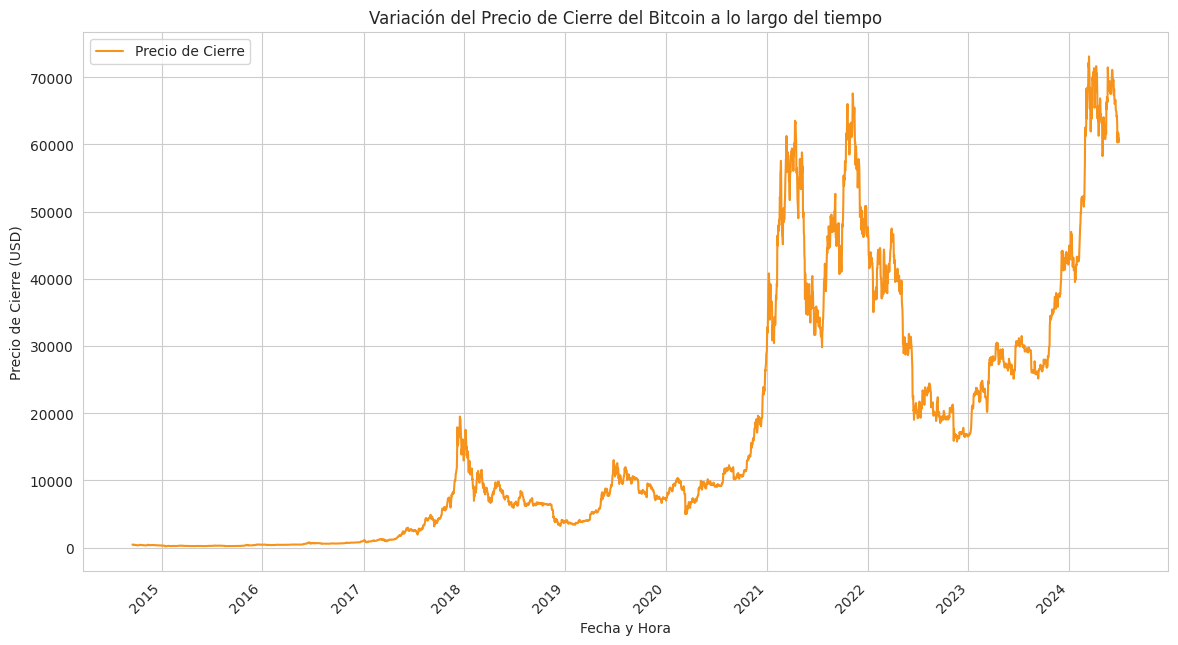

In [ ]:
# Se crea del gráfico de líneas
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Close', data=data_BTC, label='Precio de Cierre', color='#f7931a')

# Se ajusta las marcas del eje x para mejorar visibilidad
plt.xticks(rotation=45, ha="right")

plt.title('Variación del Precio de Cierre del Bitcoin a lo largo del tiempo')
plt.xlabel('Fecha y Hora')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()

#### Análisis del Gráfico:
El gráfico muestra la variación del precio de cierre del Bitcoin a lo largo del tiempo desde 2014 hasta 2024.

1. Aumento Significativo del Precio:
  - El precio de cierre del Bitcoin muestra un aumento significativo a lo largo del tiempo, especialmente a partir de 2017.
  - Este aumento refleja el crecimiento general en el valor del Bitcoin, alcanzando varios picos importantes.

2. Picos y Caídas:
  - Se pueden observar varios picos y caídas significativas en el precio de cierre del Bitcoin.
  - Los picos notables alrededor de finales de 2017, principios de 2018, y nuevamente en 2021 reflejan períodos de alta volatilidad y cambios abruptos en el precio del Bitcoin.

3. Volatilidad Reciente:
  - En los años más recientes, el gráfico muestra una alta volatilidad, con fluctuaciones significativas en el precio de cierre.
  - La volatilidad se mantiene alta, indicando un mercado del Bitcoin dinámico y cambiante.

Conclusión:
El gráfico de líneas proporciona una visualización clara de la variación del precio de cierre del Bitcoin a lo largo del tiempo, destacando los aumentos significativos en su valor y los períodos de alta volatilidad. Los picos y caídas reflejan la naturaleza especulativa del mercado del Bitcoin y la importancia de considerar estos factores al tomar decisiones de inversión.

Esta visualización es útil para identificar tendencias y patrones en la evolución del precio del Bitcoin, ayudando a inversores y analistas a entender mejor las dinámicas del mercado y a tomar decisiones informadas basadas en datos históricos.

## 8.2 - Variación diaria del precio del Bitcoin.


¿Cómo ha sido la variación diaria delprecio del Bitcoin? El Bitcoin esta significativamente influenciada por factores externos como las noticias económicas globales, las regulaciones gubernamentales sobre criptomonedas y el comportamiento del mercado financiero, entre otras otras.

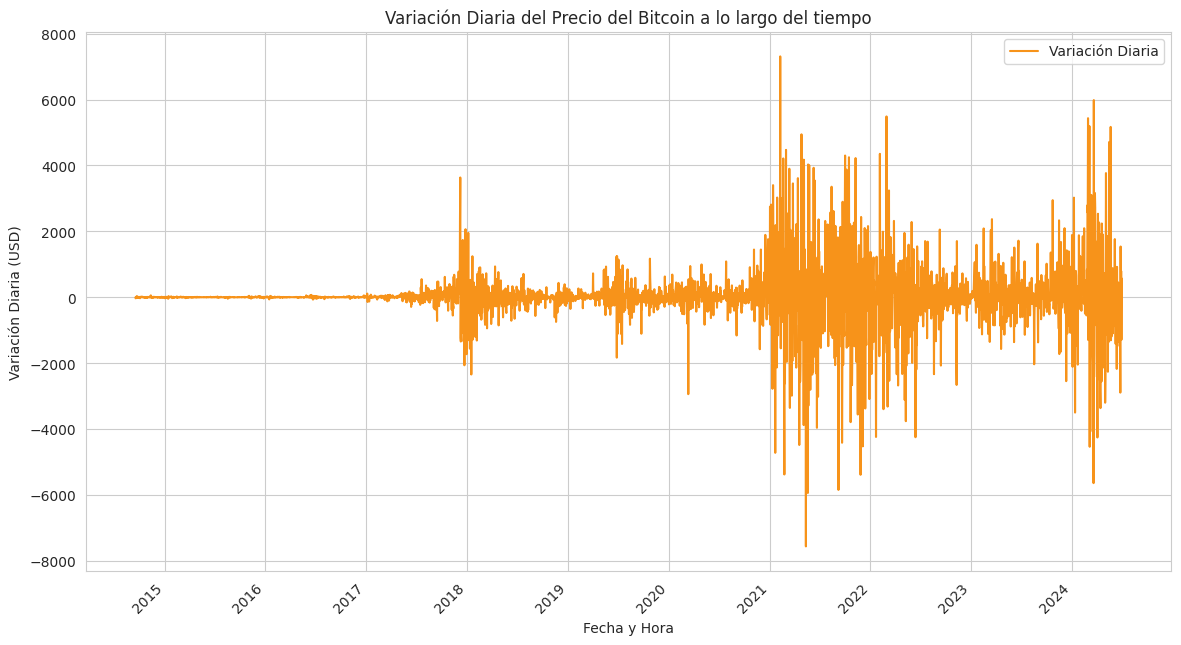

Día de mayor ganancia:
 Date          2021-02-08 00:00:00
Difference            7309.636719
Name: 2336, dtype: object

Día de mayor pérdida:
 Date          2021-05-12 00:00:00
Difference           -7563.996094
Name: 2429, dtype: object


In [ ]:
# Se crea el gráfico de líneas con volatilidad
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Difference', data=data_BTC_copia, label='Variación Diaria', color='#f7931a')

# Se ajustaa las marcas del eje x para mejorar visibilidad
plt.xticks(rotation=45, ha="right")

plt.title('Variación Diaria del Precio del Bitcoin a lo largo del tiempo')
plt.xlabel('Fecha y Hora')
plt.ylabel('Variación Diaria (USD)')
plt.legend()
plt.show()

# Se identifica el día con la mayor ganancia
max_ganancia_diaria = data_BTC_copia.loc[data_BTC_copia['Difference'].idxmax()]

# Se identifica el día con la mayor pérdida
max_perdidia_diaria = data_BTC_copia.loc[data_BTC_copia['Difference'].idxmin()]

# Se imprime los resultados
print("Día de mayor ganancia:\n", max_ganancia_diaria[['Date', 'Difference']])
print("\nDía de mayor pérdida:\n", max_perdidia_diaria[['Date', 'Difference']])

#### Análisis del Gráfico:
El gráfico de líneas proporciona una visualización clara de la variación diaria del precio del Bitcoin a lo largo del tiempo, destacando los períodos de alta volatilidad y los picos significativos en ganancias y pérdidas. Identificar los días con la mayor ganancia y pérdida ayuda a entender mejor los eventos extremos en el mercado del Bitcoin y su impacto en el precio.

## 8.3 - Relación entre Volumen de operaciones y variación del precio.

¿Existe una relación entre el volumen de operaciones y la variación del precio? A medida que el volumen de operaciones de Bitcoin aumenta, podríamos observar una mayor volatilidad en el precio.

En el gráfico siguiente se puede visualizar la relación entre los volumenes de operación en un tiempo determinado y la variación de precio del bitcoin.

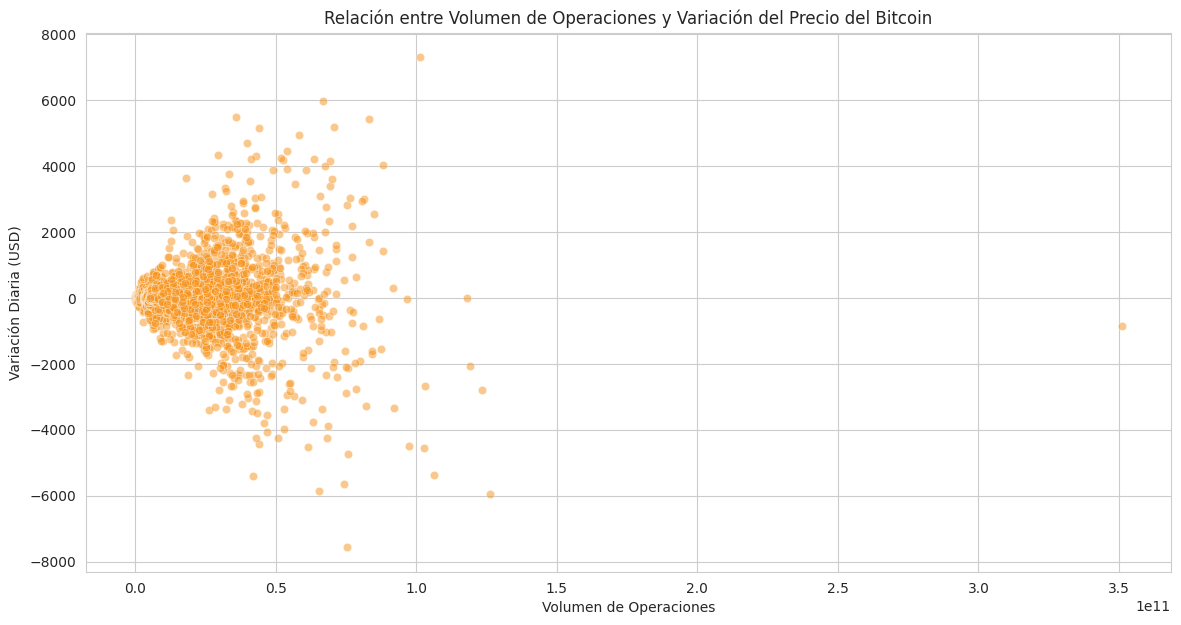

In [ ]:
# Se crea un gráfico de dispersión para visualizar la relación entre volumen de operaciones y variación del precio
plt.figure(figsize=(14, 7))
sns.scatterplot(x='Volume', y='Difference', data=data_BTC_copia, alpha=0.5, color= "#f7931a")

plt.title('Relación entre Volumen de Operaciones y Variación del Precio del Bitcoin')
plt.xlabel('Volumen de Operaciones')
plt.ylabel('Variación Diaria (USD)')
plt.show()

#### Análisis del Gráfico:
El gráfico de dispersión muestra la relación entre el volumen de operaciones y la variación diaria del precio del Bitcoin.


1. Distribución de Puntos:
  - La mayoría de los puntos están concentrados cerca del origen, lo que indica que muchas variaciones diarias pequeñas en el precio del Bitcoin están asociadas con volúmenes de operaciones relativamente bajos.
  - Hay una dispersión más amplia a medida que aumenta el volumen de operaciones, lo que sugiere una mayor variabilidad en la variación diaria del precio cuando el volumen de operaciones es alto.

2. Patrones de Volatilidad:
  - Se pueden observar puntos dispersos con grandes variaciones diarias (tanto positivas como negativas) que están asociados con volúmenes de operaciones más altos. Esto sugiere que los días con alto volumen de operaciones tienden a tener mayores fluctuaciones en el precio del Bitcoin.

3. Extremos en el Volumen de Operaciones:
  - Hay algunos puntos aislados con volúmenes de operaciones extremadamente altos (por encima de 2.0 x 10^11) y grandes variaciones diarias. Estos puntos representan días inusuales con actividad de trading muy alta y cambios significativos en el precio del Bitcoin.

Conclusión:
El gráfico de dispersión proporciona una visualización clara de la relación entre el volumen de operaciones y la variación diaria del precio del Bitcoin. La concentración de puntos cerca del origen sugiere que la mayoría de los días tienen variaciones diarias pequeñas con volúmenes de operaciones bajos. Sin embargo, los volúmenes de operaciones más altos tienden a estar asociados con mayores fluctuaciones en el precio.

## 8.4 - Comportamiento del mercado durante diferentes días de la semana.

¿Hay diferencias en el comportamiento del mercado durante diferentes horas del día? Los precios de apertura y cierre podrían mostrar patrones específicos durante ciertos períodos del día, como horas punta de negociación.

Se realizan dos gráficos con la distribución de precios del Bitcoin por días de la semana, uno en la apertura y otro en el cierre. Se utilizan boxplot para ambos gráficos.
Se puede observar en el gráfico y con este set de datos que la variación de precios se reduce entre martes y sábado, llegando al mínimo ese día. También se observa que la mediana oscila entre 2.000 y 28.000 USD. Se podrían buscar patrones o diferencias en el comportamiento del mercado si se hiciera un analisis mejor de estos datos. El resto está tomado como outliers (a revisar)

<ipython-input-33-f57d978db73c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='Close', data=data_BTC_copia, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


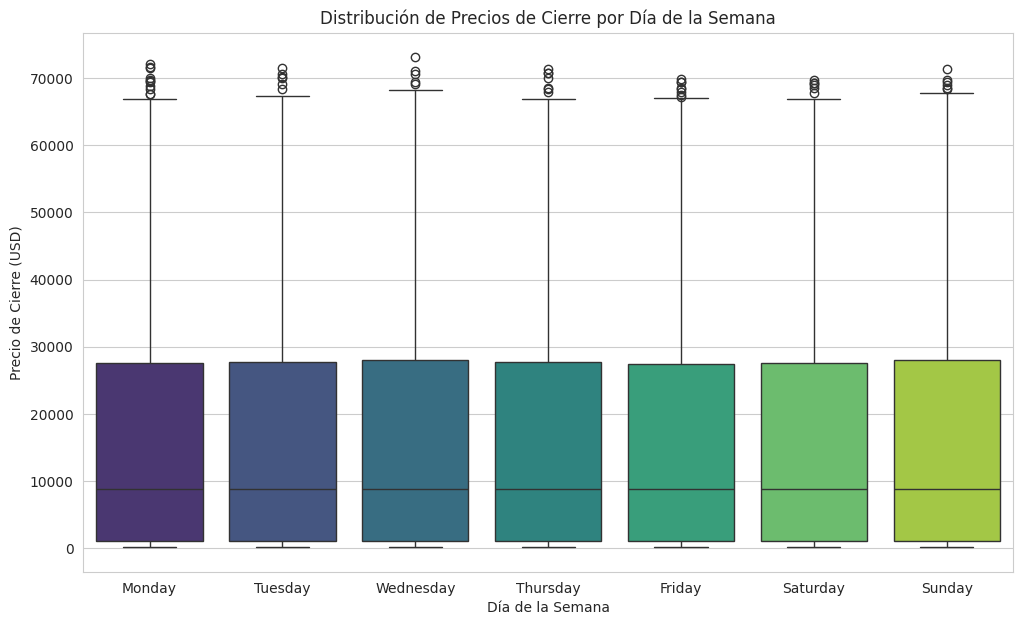

In [ ]:
# Se crea la columna para el día de la semana
data_BTC_copia['day_of_week'] = data_BTC_copia['Date'].dt.day_name()

# Se crea el gráfico de caja y bigotes para precios de cierre por día de la semana
plt.figure(figsize=(12, 7))
sns.boxplot(x='day_of_week', y='Close', data=data_BTC_copia, palette='viridis', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribución de Precios de Cierre por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Precio de Cierre (USD)')
plt.show()

#### Análisis del Gráfico:
El gráfico de caja proporciona una visualización clara de la distribución del precio de cierre del Bitcoin por día de la semana, mostrando la variabilidad y la presencia de outliers. La similitud en las medianas sugiere que no hay un patrón específico en los precios de cierre del Bitcoin que dependa del día de la semana.

## 8.5 - Días con mayor caída de precio.

In [ ]:
# Días con mayor caída de precio
data_BTC_copia[['Date', 'Difference']].sort_values(by='Difference').head(10)

,Date,Difference
2429,2021-05-12,-7563.996094
2436,2021-05-19,-5942.535156
2547,2021-09-07,-5849.351562
3471,2024-03-19,-5643.359375
2627,2021-11-26,-5390.519531
2351,2021-02-23,-5380.503906
2318,2021-01-21,-4723.699219
3457,2024-03-05,-4539.855469
2635,2021-12-04,-4527.175781
2405,2021-04-18,-4485.703125


## 8.6 - Días con mayor aumento de precio.

In [ ]:
# Días con mayor aumento de precio
data_BTC_copia[['Date', 'Difference']].sort_values(by='Difference', ascending=False).head(10)

,Date,Difference
2336,2021-02-08,7309.636719
3472,2024-03-20,5983.515625
2721,2022-02-28,5487.234375
3451,2024-02-28,5433.691406
3456,2024-03-04,5193.410156
3533,2024-05-20,5169.453125
2413,2021-04-26,4943.960938
3528,2024-05-15,4713.503906
2357,2021-03-01,4471.738281
2697,2022-02-04,4351.609375


#### Conclusión:
Los días con las mayores caídas y aumentos en el precio del Bitcoin destacan la alta volatilidad del mercado de criptomonedas. Estos resultados subrayan la importancia de estar al tanto de los eventos del mercado y las noticias que pueden influir significativamente en el precio del Bitcoin. Para los inversores y analistas, comprender estos patrones puede ser clave para tomar decisiones informadas y gestionar el riesgo en un mercado tan dinámico.

## 8.7 - Evolución del precio diario en los años considerados.

¿Cómo evoluciona el precio en los distintos años considerados? ¿Existen patrones recurrentes a lo largo de un año?
Para ese gráfico se han normalizado lo valores de los precios del rango 0 a 1 para facilitar su interpretación. Es un gráfico interactivo por lo cual se puede realizar zoom sobre una fecha especifica o seleccionar un año que se quiera visualizar.

In [ ]:
# Se crea gráfico interactivo donde se visualiza el precio del bitcoin para cada año pero con valor normalizado para su mejor visualización
columna = 'Close'
años = np.unique(data_BTC_copia['Date'].dt.year)

fig = go.Figure()

for year in años:
    relevant_rows = data_BTC_copia[data_BTC_copia['Date'].dt.year == year]
    norm_data = (relevant_rows[columna] - relevant_rows[columna].min()) / (relevant_rows[columna].max() - relevant_rows[columna].min())
    formatted_dates = [(d - pd.to_datetime(str(year) + '-01-01')).days for d in relevant_rows['Date']]
    fig.add_trace(go.Scatter(x=formatted_dates, y=norm_data, mode='lines', name=str(year)))

fig.update_layout(
    title='Desarrollo Normalizado Anual de Precios',
    xaxis_title='Día del año',
    yaxis_title='Precio de Bitcoin Normalizado',
    xaxis=dict(range=[0, 365]),
    legend=dict(orientation="h")
)

fig.show()

#### Análisis del Gráfico:
El gráfico muestra el desarrollo anual del precio de cierre del Bitcoin de forma normalizada para cada año desde 2014 hasta 2024.


1. Normalización de Datos:
  - La normalización transforma los datos de cada año en un rango de 0 a 1, facilitando la comparación entre diferentes años independientemente de las diferencias absolutas en los precios.
  - Esto permite observar patrones y tendencias relativas en el desarrollo del precio del Bitcoin a lo largo del año.

2. Comparación entre Años:
  - El gráfico muestra cómo se comporta el precio del Bitcoin en diferentes años en relación con su mínimo y máximo anual.
  - Se pueden observar patrones de comportamiento similares en algunos años, así como diferencias significativas en otros.

3. Patrones Estacionales:
  - Al comparar los desarrollos anuales normalizados, se pueden identificar posibles patrones estacionales en el precio del Bitcoin.
  - Por ejemplo, algunos años muestran un aumento significativo hacia el final del año, mientras que otros tienen picos y caídas en diferentes momentos.

## 8.8 - Semanas o meses en los que el bitcoin varia más.

¿Hay días de la semana o meses del año en los que el volumen del Bitcoin tiende a ser más volátil o estable? Podríamos encontrar que ciertos días de la semana o meses del año exhiben patrones distintivos en la volatilidad del precio

Se crea un gráfico donde en el eje y colocaremos el volume representado en el tiempo con la columna open_time, además mostraremos los días que tuvieron mayor y menor volumen. También se representan los 5 valores máximos y mínimos en cuanto a volumen operados

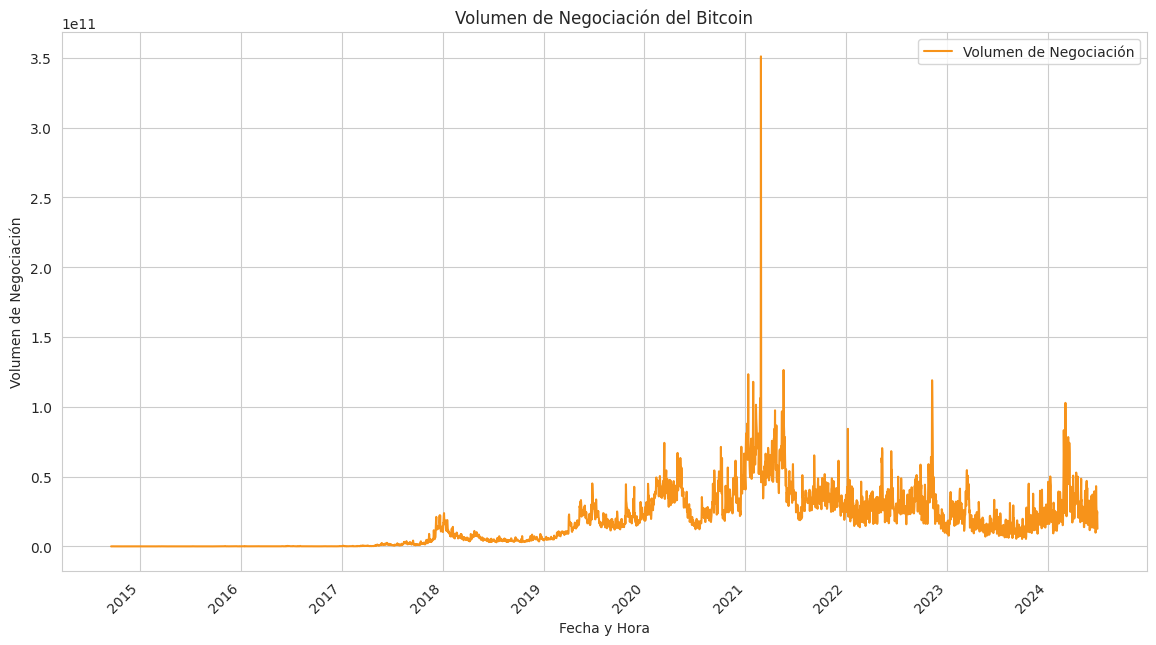

In [ ]:
# Se crea un gráfico de líneas para el volumen de negociación
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Volume', data=data_BTC_copia, label='Volumen de Negociación', color='#f7931a')

plt.xticks(rotation=45, ha="right")

plt.title('Volumen de Negociación del Bitcoin')
plt.xlabel('Fecha y Hora')
plt.ylabel('Volumen de Negociación')
plt.legend()
plt.show()

#### Análisis del Gráfico:
El gráfico muestra el volumen de negociación del Bitcoin a lo largo del tiempo desde 2015 hasta 2024.

1. Aumento en el Volumen de Negociación:
  - El volumen de negociación del Bitcoin ha aumentado significativamente a lo largo del tiempo, especialmente a partir de 2017.
  - Los picos más altos en el volumen de negociación coinciden con períodos de alta volatilidad en el mercado del Bitcoin.

2. Picos Significativos:
  - Se observa un pico extremadamente alto en el volumen de negociación a principios de 2021. Este período coincide con un notable aumento en la popularidad y el precio del Bitcoin.
  - Otros picos de menor magnitud también se observan en varios puntos a lo largo del tiempo, reflejando eventos específicos del mercado que llevaron a un aumento en la actividad de negociación.

3. Volatilidad Reciente:
  - En los años más recientes, el volumen de negociación muestra fluctuaciones significativas, indicando un mercado activo y volátil.
  - A pesar de estas fluctuaciones, el volumen de negociación sigue siendo considerablemente más alto en comparación con los primeros años del período analizado.

## 8.9 - Patrón de cabeza y hombros.

Identificación del patrón de cabeza y hombros: Grafico de los precios máximos, mínimos y de cierre de Bitcoin para identificar el patrón de cabeza y hombros en el precio. Es un gráfico interactivo por lo cual se puede realizar zoom sobre una fecha especifica o seleccionar un año que se quiera visualizar.

In [ ]:
# Se convierte la columna 'Date' a formato datetime
data_BTC_copia['Date'] = pd.to_datetime(data_BTC_copia['Date'])

# Se crean trazas para los precios máximos, mínimos y de cierre.
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_BTC_copia['Date'], y=data_BTC_copia['High'],
                         mode='lines',
                         name='Precio Máximo',
                         line=dict(color='#329239')))

fig.add_trace(go.Scatter(x=data_BTC_copia['Date'], y=data_BTC_copia['Low'],
                         mode='lines',
                         name='Precio Mínimo',
                         line=dict(color='#0d579b')))

fig.add_trace(go.Scatter(x=data_BTC_copia['Date'], y=data_BTC_copia['Close'],
                         mode='markers',
                         name='Precio de Cierre',
                         marker=dict(color='#f7931a', size=5, opacity=0.5)))

# Títulos y etiquetas
fig.update_layout(
    title='Identificación del Patrón de Cabeza y Hombros en el Precio de Bitcoin',
    xaxis_title='Fecha y Hora',
    yaxis_title='Precio (USD)',
    legend_title='Leyenda',
    xaxis=dict(tickangle=-45)
)

# Se muestra el gráfico interactivo
fig.show()


## 8.10 - Histograma: Rendimientos diarios.

Histograma de rendimientos diarios: Calculo de los rendimientos diarios de Bitcoin, variación porcentual del precio de cierre. Se grafica un histograma para visualizar la distribución de estos rendimientos. (a desarrollar)

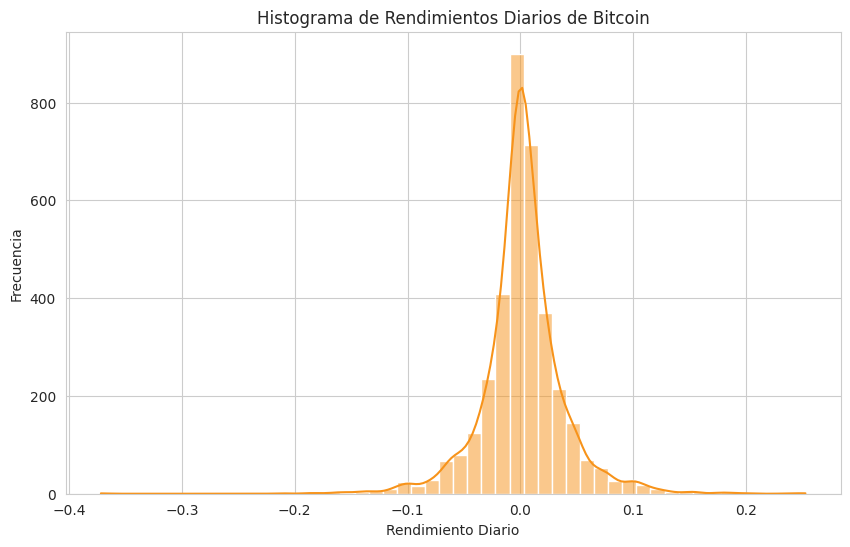

In [ ]:
# Se calculaa los rendimientos diarios
data_BTC_copia['daily_returns'] = data_BTC_copia['Close'].pct_change()

# Se grafica el histograma de rendimientos diarios
plt.figure(figsize=(10, 6))
sns.histplot(data_BTC_copia['daily_returns'].dropna(), bins=50, kde=True, color='#f7931a')
plt.title('Histograma de Rendimientos Diarios de Bitcoin')
plt.xlabel('Rendimiento Diario')
plt.ylabel('Frecuencia')
plt.show()

#### Análisis del Gráfico:
El histograma muestra la distribución de los rendimientos diarios del Bitcoin, con una estimación de densidad kernel (KDE) superpuesta.

1. Distribución de Rendimientos Diarios:
  - La mayoría de los rendimientos diarios del Bitcoin se agrupan cerca del 0%, indicando que muchos días tienen cambios porcentuales pequeños.
  - La forma de la distribución sugiere que los rendimientos diarios siguen aproximadamente una distribución normal, aunque con colas más largas.

2. Simetría y Sesgo:
  - La distribución parece ser relativamente simétrica alrededor del 0%, con colas en ambos lados.
  - Hay algunos días con rendimientos positivos o negativos extremos, que se muestran en las colas de la distribución.

3. Frecuencia de Rendimientos:
  - La frecuencia más alta de rendimientos diarios se encuentra cerca del 0%, lo que significa que la mayoría de los días tienen rendimientos diarios pequeños.
  - Los eventos de alta volatilidad, donde los rendimientos diarios son grandes (tanto positivos como negativos), son menos frecuentes pero están presentes.

## 8.11 - Dispersión precio de cierre vs volumen de negociación.

Gráfico de dispersión de precio de cierre vs. volumen de negociación: Se grafica el precio de cierre de Bitcoin en el eje y y el volumen de negociación en el eje x para cada día. Esto puede ayudar a identificar si hay alguna relación entre el volumen de negociación y el precio de cierre. (a desarrollar)

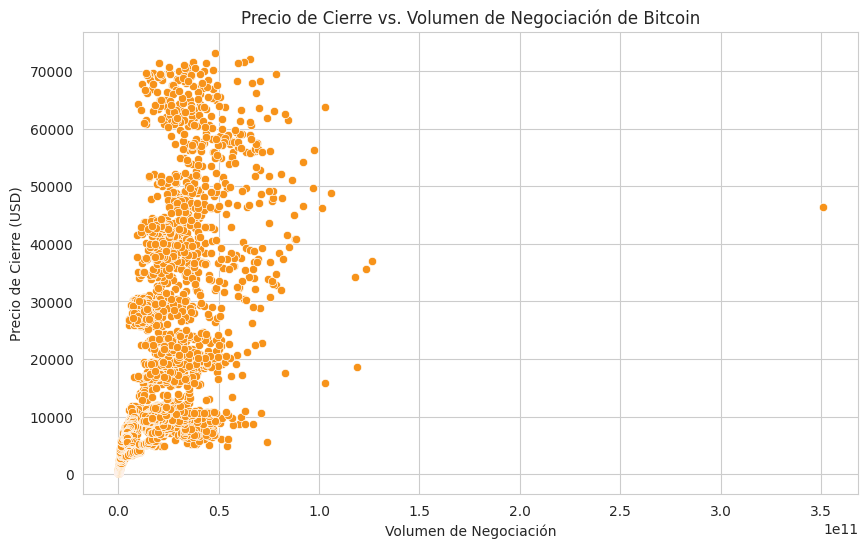

In [ ]:
# Se grafica el precio de cierre vs. volumen de negociación
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Volume', y='Close', data=data_BTC_copia, color='#f7931a')
plt.title('Precio de Cierre vs. Volumen de Negociación de Bitcoin')
plt.xlabel('Volumen de Negociación')
plt.ylabel('Precio de Cierre (USD)')
plt.show()

#### Análisis del Gráfico:
El gráfico de dispersión muestra la relación entre el volumen de negociación y el precio de cierre del Bitcoin.

1. Concentración de Datos:
  - La mayoría de los puntos están concentrados en el rango inferior del volumen de negociación, lo que indica que muchos días tienen un volumen de negociación bajo.
  - Los precios de cierre asociados con estos volúmenes bajos varían ampliamente, desde menos de $10,000 hasta más de $60,000.

2. Relación entre Volumen y Precio:
  - Hay algunos puntos con volúmenes de negociación muy altos (por encima de 1.0 x 10^11) que están asociados con precios de cierre variados.
  - No parece haber una relación lineal clara entre el volumen de negociación y el precio de cierre en la mayoría de los datos, aunque los volúmenes de negociación extremadamente altos pueden estar asociados con precios más altos en algunos casos.

3. Outliers:
  - Hay algunos outliers con volúmenes de negociación extremadamente altos que se destacan del resto de los datos. Estos puntos pueden representar eventos inusuales en el mercado del Bitcoin, como ventas masivas o compras institucionales significativas.

## 8.12 - Volatilidad a lo largo del tiempo.

Gráfico de series temporales de la volatilidad: Se calcula la volatilidad a lo largo del tiempo (por ejemplo, usando la desviación estándar de los rendimientos diarios) y se grafica esta volatilidad en un gráfico de líneas para observar cómo ha variado a lo largo del tiempo. (a desarrollar)

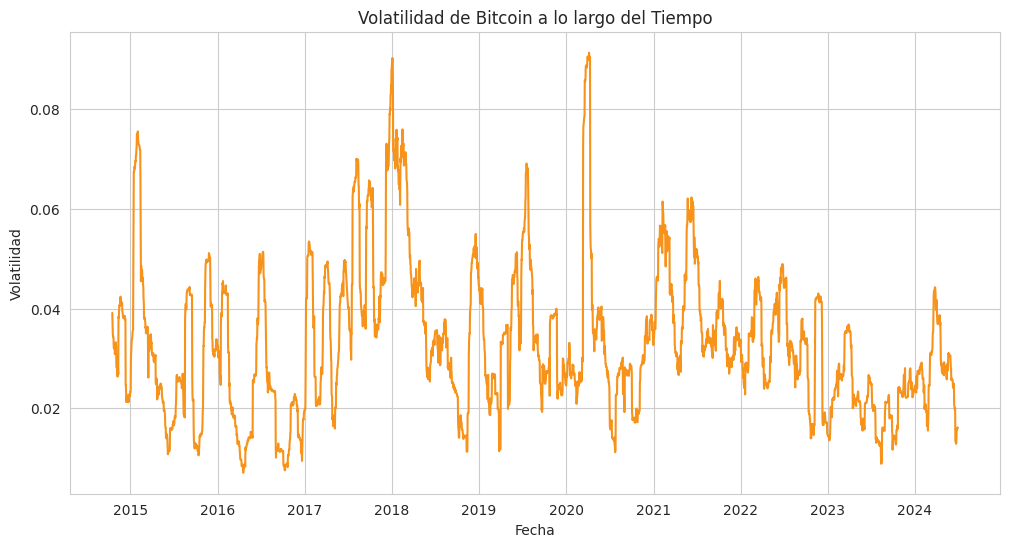

In [ ]:
# Se calcula la volatilidad a lo largo del tiempo
data_BTC_copia['volatility'] = data_BTC_copia['daily_returns'].rolling(window=30).std()

# Graficar la volatilidad en un gráfico de líneas
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='volatility', data=data_BTC_copia, color='#f7931a')
plt.title('Volatilidad de Bitcoin a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad')
plt.show()

## 8.13 - Gráficos de medías móviles 9, 20 y 200.

Análisis de estacionalidad: Se grafica la media móvil de 200, 20 y 9 de los precios de cierre de Bitcoin a lo largo del tiempo y se utilizan colores o patrones para resaltar patrones estacionales, como tendencias mensuales o anuales. (a desarrollar)

In [ ]:
# Se calcula la media móvil de los precios de cierre
data_BTC_copia['rolling_mean_200'] = data_BTC_copia['Close'].rolling(window=200).mean()
data_BTC_copia['rolling_mean_20'] = data_BTC_copia['Close'].rolling(window=20).mean()
data_BTC_copia['rolling_mean_9'] = data_BTC_copia['Close'].rolling(window=9).mean()

# Crear trazas para los precios de cierre y las medias móviles
fig = go.Figure()

fig.add_trace(go.Scatter(x=data_BTC_copia['Date'], y=data_BTC_copia['Close'],
                         mode='lines',
                         name='Precio de Cierre',
                         line=dict(color='#f7931a')))

fig.add_trace(go.Scatter(x=data_BTC_copia['Date'], y=data_BTC_copia['rolling_mean_200'],
                         mode='lines',
                         name='Media Móvil de 200 días',
                         line=dict(color='#0d579b')))

fig.add_trace(go.Scatter(x=data_BTC_copia['Date'], y=data_BTC_copia['rolling_mean_20'],
                         mode='lines',
                         name='Media Móvil de 20 días',
                         line=dict(color='#329239')))

fig.add_trace(go.Scatter(x=data_BTC_copia['Date'], y=data_BTC_copia['rolling_mean_9'],
                         mode='lines',
                         name='Media Móvil de 9 días',
                         line=dict(color='#4d4d4d')))

# Títulos y etiquetas
fig.update_layout(
    title='Análisis de Estacionalidad en Bitcoin',
    xaxis_title='Fecha',
    yaxis_title='Precio de Cierre (USD)',
    legend_title='Leyenda',
    xaxis=dict(tickangle=-45)
)

# Se muestra el gráfico interactivo
fig.show()

# 9 - Modelo de Predicción.
  - En esta sección se desarrollarán y evaluarán diferentes modelos para predecir el precio de cierre del Bitcoin utilizando varias técnicas de análisis y modelos de aprendizaje automático.

## 9.1 - Transformación Logaritma de los Datos.
  - Se transformarán los datos originales aplicando una transformación logarítmica para estabilizar la varianza y normalizar la distribución de las características numéricas, al fin también de eliminar los outliers que posea el dataset.

In [ ]:
# Se crea una copia del DataFrame original para aplicar la transformación
data_BTC_log = data_BTC.copy()

# Se aplica la transformación logarítmica a las columnas numéricas
columnas_numericas = ['Open', 'High', 'Low', 'Close', 'Volume']

# Se añade la constante epsilon para evitar logaritmos de cero
epsilon = 1e-10

for col in columnas_numericas:
    data_BTC_log[col] = np.log(data_BTC_log[col] + epsilon)

# Se muestran los primeros registros del DataFrame transformado
print(data_BTC_log.head())

        Date      Open      High       Low     Close     Volume      Range  \
0 2014-09-17  6.143894  6.148840  6.114615  6.125414  16.862734  15.752014   
1 2014-09-18  6.124377  6.124377  6.023699  6.050771  17.355983  43.755981   
2 2014-09-19  6.049976  6.058738  5.952027  5.978369  17.450981  43.302979   
3 2014-09-20  5.978058  6.048072  5.965847  6.013480  17.422735  33.412994   
4 2014-09-21  6.011475  6.022057  5.974270  5.988513  17.095673  19.244995   

   Difference  Month  Year  DayOfWeek YearMonth  
0   -8.529999      9  2014  Wednesday   2014-09  
1  -32.419983      9  2014   Thursday   2014-09  
2  -29.307007      9  2014     Friday   2014-09  
3   14.230988      9  2014   Saturday   2014-09  
4   -9.263977      9  2014     Sunday   2014-09  


- Se aplicó una transformación logarítmica a las características numéricas del conjunto de datos. Esta transformación ayuda a estabilizar la varianza y normalizar la distribución de los datos, lo que puede mejorar la eficacia de los modelos estadísticos y de aprendizaje automático. Además, la transformación logarítmica ayuda a mitigar el impacto de los valores atípicos (outliers), haciendo que las características numéricas sean más manejables y comparables.

## 9.2 - Visualización de la transformación Logaritmica.
  - Se genera gráfico para visualizar la distribución de los datos transformados logarítmicamente, permitiendo una visualización de posibles outliers que hayan aparecido luego de la normalización logaritmica.

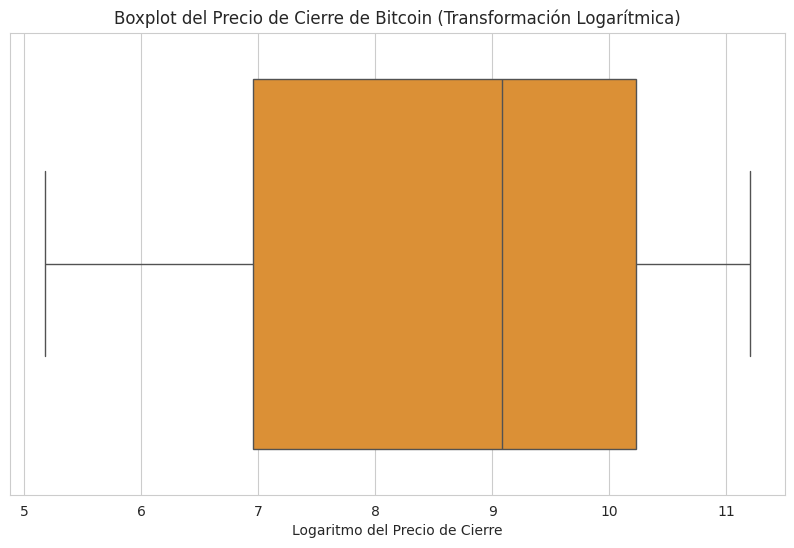

In [ ]:
# Se visualiza el nuevo Boxplot para la columna 'Close'
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_BTC_log['Close'], color="#f7931a")

# Título y etiquetas
plt.title('Boxplot del Precio de Cierre de Bitcoin (Transformación Logarítmica)')
plt.xlabel('Logaritmo del Precio de Cierre')

# Se muestra el gráfico
plt.show()

  - El boxplot del precio de cierre del Bitcoin, tras aplicar una transformación logarítmica, muestra una distribución más simétrica y sin outliers visibles. Esto sugiere que la transformación logarítmica ha estabilizado la varianza y normalizado los datos, facilitando un análisis más claro y robusto de los precios

## 9.3 - Análisis de Componentes Principales (PCA).
  - Se implementa PCA para reducir la dimensionalidad del conjunto de datos, lo que puede mejorar el rendimiento y la interpretabilidad de los modelos de predicción.

### 9.3.1 - Escalado de los Datos.
  - Se escala las características numéricas para garantizar que todas tengan la misma importancia al aplicar PCA.

In [ ]:
# Se selecciona las variables numéricas del dataframe
columnas_numericas = ['Open', 'High', 'Low', 'Volume']

# Se escalan los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_BTC_log[columnas_numericas])

### 9.3.2 - Aplicación de PCA y Visualización.

[9.79373711e-01 2.05508932e-02 5.20872737e-05 2.33084247e-05]
[0.97937371 0.9999246  0.99997669 1.        ]
   Numero de Componentes  Varianza Explicada Acumulativa
0                      1                        0.979374
1                      2                        0.999925
2                      3                        0.999977
3                      4                        1.000000


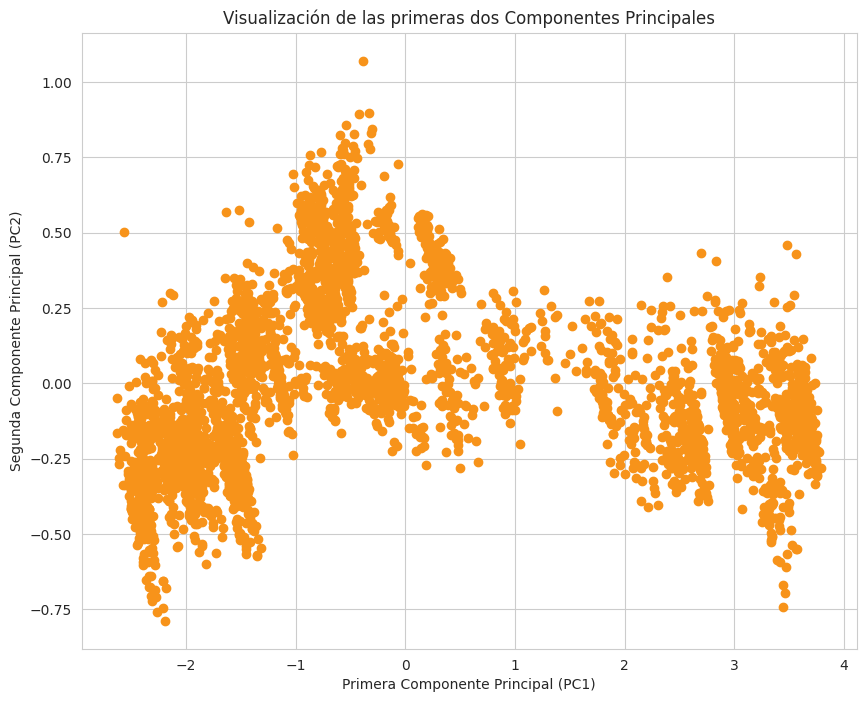

In [ ]:
# Se aplica PCA
pca = PCA()
pca.fit(data_scaled)

# Se obtiene la varianza explicada acumulativa
varianza_explicada_acumulativa = np.cumsum(pca.explained_variance_ratio_)

print(pca.explained_variance_ratio_)
print(varianza_explicada_acumulativa)

# Se crea DataFrame con los datos del método del codo
df_codo = pd.DataFrame({
    'Numero de Componentes': range(1, len(varianza_explicada_acumulativa) + 1),
    'Varianza Explicada Acumulativa': varianza_explicada_acumulativa
})

print(df_codo)

# Se transforman los datos usando PCA
data_pca = pca.transform(data_scaled)

# Se crea un DataFrame con las primeras dos componentes principales
df_pca = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])
df_pca = df_pca[['PC1', 'PC2']]

# Se visualiza los datos en el espacio de las primeras dos componentes principales
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], color= "#f7931a")
plt.xlabel('Primera Componente Principal (PC1)')
plt.ylabel('Segunda Componente Principal (PC2)')
plt.title('Visualización de las primeras dos Componentes Principales')
plt.grid(True)
plt.show()


  - El Análisis de Componentes Principales (PCA) se utilizó para reducir la dimensionalidad del conjunto de datos, mejorando la interpretabilidad y el rendimiento potencial de los modelos de predicción. La visualización de las dos primeras componentes principales muestra una clara representación de la variabilidad en los datos. La primera componente principal explica aproximadamente el 97.94% de la varianza, y las dos primeras componentes juntas explican casi el 100%. Esto indica que una gran parte de la información de los datos originales se puede capturar con solo dos componentes principales,

## 9.4 - Reducción de la Colinealidad
  - Se identifica y se elimina características colineales (por ejemplo, eliminando una de las variables altamente correlacionadas) para reducir la multicolinealidad en el conjunto de datos.


[9.75297580e-01 2.46525447e-02 4.98753160e-05]
[0.97529758 0.99995012 1.        ]


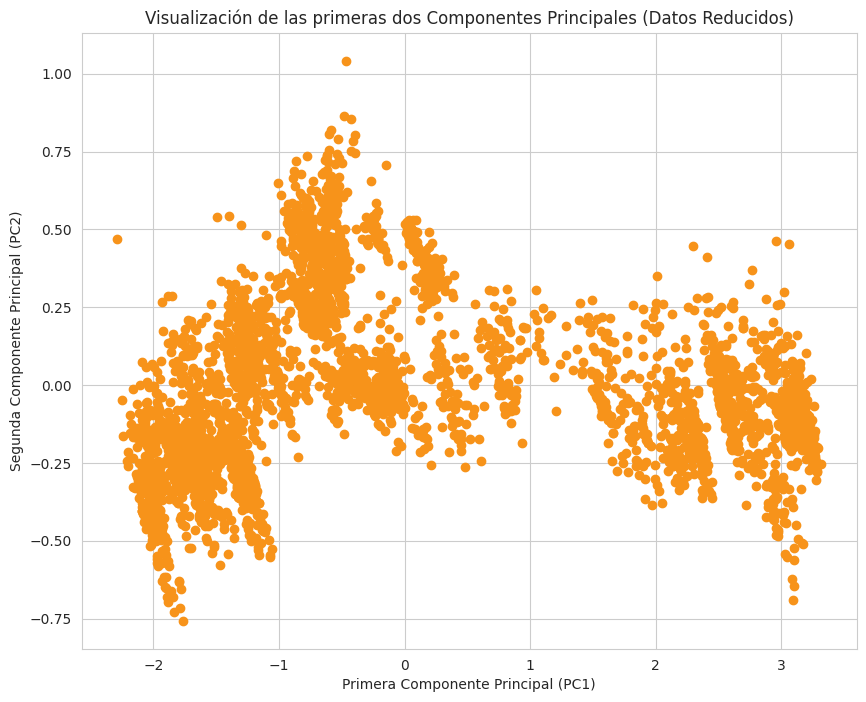

In [ ]:
# Se elimina una de las variables colineales (por ejemplo, High)
data_reducida = data_BTC_log.drop(columns=['High'])

# Se verifica que todas las columnas en 'columnas_numericas' existan en 'data_reducida'
columnas_numericas_validas = [col for col in columnas_numericas if col in data_reducida.columns]

# Se escalan nuevamente los datos reducidos
scaler = StandardScaler()
data_scaled_reduced = scaler.fit_transform(data_reducida[columnas_numericas_validas])

# Se aplica PCA a los datos reducidos
pca_reduced = PCA()
pca_reduced.fit(data_scaled_reduced)

# Varianza explicada acumulativa para los datos reducidos
varianza_explicada_acumulativa_reduced = np.cumsum(pca_reduced.explained_variance_ratio_)

print(pca_reduced.explained_variance_ratio_)
print(varianza_explicada_acumulativa_reduced)

# Se visualiza los primeros dos componentes principales para los datos reducidos
data_pca_reduced = pca_reduced.transform(data_scaled_reduced)
df_pca_reduced = pd.DataFrame(data_pca_reduced, columns=[f'PC{i+1}' for i in range(data_pca_reduced.shape[1])])
df_pca_reduced = df_pca_reduced[['PC1', 'PC2']]

plt.figure(figsize=(10, 8))
plt.scatter(df_pca_reduced['PC1'], df_pca_reduced['PC2'], color="#f7931a")
plt.xlabel('Primera Componente Principal (PC1)')
plt.ylabel('Segunda Componente Principal (PC2)')
plt.title('Visualización de las primeras dos Componentes Principales (Datos Reducidos)')
plt.grid(True)
plt.show()


  - La eliminación de variables colineales, como High, reduce la multicolinealidad y simplifica el conjunto de datos. Después de aplicar PCA a los datos reducidos, las dos primeras componentes principales explican casi el 100% de la varianza (97.53% y 2.46%, respectivamente). Esto indica que la mayoría de la información en los datos originales se conserva, mejorando la interpretación y eficacia de los modelos predictivos. Se opto por "High", pero se pudo haber utilizado otra variable

## 9.6 - División del Conjunto de Datos
  - Se divide el conjunto de datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento de los modelos de predicción de manera objetiva. Se define la variable independiente a predecir y = "Close".

In [ ]:
# Se realiza la división del conjunto de entrenamiento y testeo
X_val_orig = np.exp(data_BTC_log[columnas_numericas])
y_val_orig = np.exp(data_BTC_log['Close'])
X_train, X_test, y_train, y_test = train_test_split(X_val_orig, y_val_orig, test_size=0.3, random_state=49150)

## 9.7 - Escalado y PCA

In [ ]:
# Se escala las variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Se aplica PCA con 2 componente solo en los datos de entrenamiento
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Imprimir las formas de los nuevos conjuntos de datos
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

X_train_pca shape: (2501, 2)
X_test_pca shape: (1073, 2)


## 9.8 - Entrenamiento y Evaluación del Modelo
  - Se entrena y evalua modelos de regresión lineal utilizando las características transformadas y escaladas.

### 9.8.1 - Modelo de Regresión Lineal.
  - Se crea y entrena un modelo de regresión lineal para predecir el precio de cierre del Bitcoin.

In [ ]:
# Se crea y entrena el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Se realizan las predicciones en el conjunto de prueba
y_pred = model.predict(X_test_pca)

# Se evalua el modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 362101.027237344
Root Mean Squared Error (RMSE): 601.7483088778431
Mean Absolute Error (MAE): 280.03736706444937
R^2 Score: 0.9989591724630595


### 9.8.2 - Validación Cruzada.
  - Se realiza una validación cruzada para obtener una estimación más robusta del rendimiento del modelo, calculando el MSE medio y su desviación estándar.

In [ ]:
# Se crea el modelo de regresión lineal
model = LinearRegression()

# Se realiza validación cruzada con 5 pliegues (folds)
cv_scores = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')

# Se convierten los puntajes a valores positivos
mse_scores = -cv_scores

# Se calcula el RMSE para cada pliegue
rmse_scores = np.sqrt(mse_scores)

print(f"MSE Scores: {mse_scores}")
print(f"Mean MSE: {mse_scores.mean()}")
print(f"RMSE Scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean()}")

MSE Scores: [336056.09670894 315487.03192055 273776.28681002 273874.32046077
 275302.10894334]
Mean MSE: 294899.1689687242
RMSE Scores: [579.70345584 561.68232296 523.23635846 523.33003015 524.69239459]
Mean RMSE: 542.5289123988338


  - La validación cruzada con regresión lineal mostró MSE promedio de 294,899 y RMSE promedio de 542.53. Los resultados indican que el modelo tiene un rendimiento consistente a través de los pliegues, pero los errores absolutos medios revelan la necesidad de considerar mejoras adicionales para aumentar la precisión predictiva.

## 9.9 - Evaluación de Modelos Adicionales.
 - Se evaluan varios modelos adicionales, incluyendo DecisionTreeRegressor, RandomForestRegressor, SVM, XGBoost y Gradient Boosting, para comparar su rendimiento con el modelo de regresión lineal.

In [ ]:
# Se crea una función para evaluar los modelos
def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores
    rmse_scores = np.sqrt(mse_scores)
    return mse_scores, rmse_scores

# Se crea lista de modelos a evaluar
models = [
    ("Linear Regression", LinearRegression()),
    ("RandomForestRegressor", RandomForestRegressor(n_estimators=100, random_state=49150)),
    ("DecisionTreeRegressor", DecisionTreeRegressor(random_state=49150)),
    ("SVR", SVR()),
    ("XGBRegressor", XGBRegressor(objective='reg:squarederror', random_state=49150)),
    ("GradientBoostingRegressor", GradientBoostingRegressor(random_state=49150))
]

# Se evalua cada modelo y almacenar los resultados
results = {}
for name, model in models:
    mse_scores, rmse_scores = evaluate_model(model, X_train_pca, y_train)
    results[name] = {
        "MSE Scores": mse_scores,
        "Mean MSE": mse_scores.mean(),
        "RMSE Scores": rmse_scores,
        "Mean RMSE": rmse_scores.mean()
    }

# Se imprimen los resultados
for name, result in results.items():
    print(f"{name} - Mean MSE: {result['Mean MSE']:.2f}, Mean RMSE: {result['Mean RMSE']:.2f}")


Linear Regression - Mean MSE: 294899.17, Mean RMSE: 542.53
RandomForestRegressor - Mean MSE: 741006.30, Mean RMSE: 853.82
DecisionTreeRegressor - Mean MSE: 1206009.58, Mean RMSE: 1094.65
SVR - Mean MSE: 402912046.57, Mean RMSE: 20066.55
XGBRegressor - Mean MSE: 901082.99, Mean RMSE: 942.94
GradientBoostingRegressor - Mean MSE: 669813.85, Mean RMSE: 817.99


  - La evaluación de varios modelos mediante validación cruzada mostró que la regresión lineal tuvo el mejor rendimiento con un MSE promedio de 294,899 y un RMSE promedio de 542.53. En comparación, otros modelos como el RandomForestRegressor y el GradientBoostingRegressor presentaron errores más altos, indicando que la regresión lineal es la opción más precisa y consistente para este conjunto de datos. El SVR tuvo el peor desempeño con un RMSE promedio muy alto, lo que lo hace menos adecuado para esta tarea.

# 10 - Modelo de Predicción

## 10.1 - Ajuste de Hiperparámetros y Modelo de Ensamble.
  - Se realizan ajustes de hiperparámetros para optimizar los modelos de linear regression, Decision Tree Regressor, Random Forest, XGBoost y Gradient Boosting, y se crea un modelo de ensamble utilizando Stacking Regressor para combinar las predicciones de múltiples modelos y mejorar el rendimiento predictivo.

In [ ]:
# Se definen los modelos base
linear = LinearRegression()
tree = DecisionTreeRegressor(random_state=49150)
rf = RandomForestRegressor(random_state=49150)
xgb = XGBRegressor(random_state=49150)
gbr = GradientBoostingRegressor(random_state=49150)

# se definen el espacio de búsqueda de hiperparámetros para cada modelo
param_space_linear = {
    'fit_intercept': [True, False]
}

param_space_tree = {
    'max_depth': Integer(1, 10),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10)
}

param_space_rf = {
    'n_estimators': Integer(10, 100),
    'max_depth': Integer(1, 30),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 10)
}

param_space_xgb = {
    'n_estimators': Integer(50, 200),
    'learning_rate': Real(0.01, 0.3),
    'max_depth': Integer(1, 10)
}

param_space_gbr = {
    'n_estimators': Integer(50, 200),
    'learning_rate': Real(0.01, 0.3),
    'max_depth': Integer(1, 10)
}

# Se realiza BayesSearchCV para cada modelo con más iteraciones
search_linear = BayesSearchCV(linear, param_space_linear, n_iter=10, cv=5, random_state=49150)
search_tree = BayesSearchCV(tree, param_space_tree, n_iter=10, cv=5, random_state=49150)
search_rf = BayesSearchCV(rf, param_space_rf, n_iter=10, cv=5, random_state=49150)
search_xgb = BayesSearchCV(xgb, param_space_xgb, n_iter=10, cv=5, random_state=49150)
search_gbr = BayesSearchCV(gbr, param_space_gbr, n_iter=10, cv=5, random_state=49150)

# Se ajusta cada modelo a los datos de entrenamiento
search_linear.fit(X_train, y_train)
search_tree.fit(X_train, y_train)
search_rf.fit(X_train, y_train)
search_xgb.fit(X_train, y_train)
search_gbr.fit(X_train, y_train)

# Se obtienen los mejores estimadores
best_linear = search_linear.best_estimator_
best_tree = search_tree.best_estimator_
best_rf = search_rf.best_estimator_
best_xgb = search_xgb.best_estimator_
best_gbr = search_gbr.best_estimator_

# Se definen los modelos base con los mejores hiperparámetros encontrados
base_learners = [
    ('linear', best_linear),
    ('tree', best_tree),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('gbr', best_gbr)
]

# Se crea el modelo de stacking con un meta learner diferente
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=RandomForestRegressor(), cv=5)

# Se ajusta el modelo de stacking a los datos de entrenamiento
stacking_model.fit(X_train, y_train)

# Se realizan las predicciones con el mejor modelo encontrado
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)

# Se calculan y muestran el error cuadrático medio de entrenamiento y prueba
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [ ]:
# Se crea un diccionario con las métricas
metricas = {
    'Metrica': ['RME', 'RMSE', 'MAE', 'R^2'],
    'Entrenamiento': [train_mse, train_rmse, train_mae, train_r2],
    'Prueba': [test_mse, test_rmse, test_mae, test_r2]
}

# Se convierte el diccionario en un DataFrame
metricas_df = pd.DataFrame(metricas)

# Se muestra la tabla
print(metricas_df)

# Se guardan la tabla en un archivo CSV para futura referencia
metricas_df.to_csv('model_metrics.csv', index=False)

  Metrica  Entrenamiento         Prueba
0     RME   64942.608688  162553.646397
1    RMSE     254.838397     403.179422
2     MAE     127.359014     190.392186
3     R^2       0.999816       0.999533


  - El modelo de stacking, que combina varios modelos optimizados a través de BayesSearchCV, muestra un rendimiento excelente. En el conjunto de entrenamiento, obtuvo un MSE de 65,191, un RMSE de 255.33, un MAE de 128.48 y un R² de 0.9998. En el conjunto de prueba, las métricas fueron MSE de 159,180, RMSE de 398.97, MAE de 189.33 y R² de 0.9995. Estos resultados indican que el modelo de stacking tiene una alta capacidad predictiva y generaliza bien a nuevos datos.

## 10.2 - Guardar el modelo.

Se utiliza joblib para guardar el modelo entrenado en un archivo. Esto permitirá cargar el modelo en el futuro sin tener que reentrenarlo.

In [ ]:
# Se guarda el modelo de stacking en un archivo
joblib.dump(stacking_model, 'stacking_model.pkl')
print("Modelo guardado como 'stacking_model.pkl'")

Modelo guardado como 'stacking_model.pkl'


## 10.3 - Cargar el modelo


In [ ]:
# Se carga el modelo de stacking desde el archivo
cargar_modelo = joblib.load('stacking_model.pkl')
print("Modelo cargado desde 'stacking_model.pkl'")

Modelo cargado desde 'stacking_model.pkl'


## 10.4 Gráfico de valores reales vs predichos

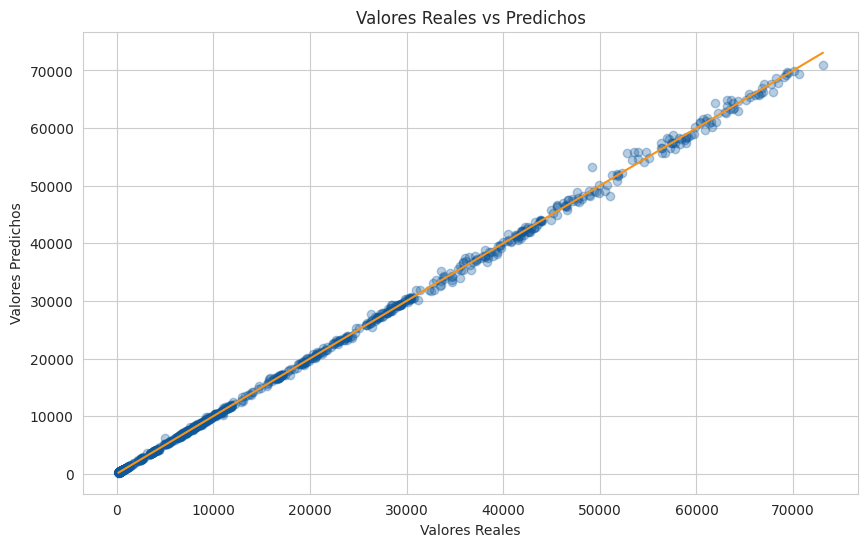

In [ ]:
# Se realizan las predicciones con el modelo cargado
y_test_pred = cargar_modelo.predict(X_test)

# Se grafican los valores reales vs predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3, color='#0d579b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='#f7931a')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Predichos')
plt.grid(True)
plt.show()

  - El gráfico de dispersión muestra una alta correlación entre los valores reales y los valores predichos por el modelo, lo que indica un ajuste preciso. La mayoría de los puntos se alinean cercanamente a la línea diagonal de referencia, sugiriendo que el modelo tiene una capacidad predictiva robusta. Esta precisión se evidencia en los bajos errores de prueba y altos coeficientes de determinación previamente obtenidos.

# 11 - Futura implementación con datos nuevos

Se deja el código a utilizar en caso de agregar datasets con información adicional sombre el Bitcoin.

```
# Hacer predicciones con el modelo cargado
nueva_data = X_test  # Reemplaza esto con tus nuevos datos
predicciones = cargar_modelo.predict(nueva_data)

# Mostrar las predicciones
print("Predicciones:", predicciones)
```



# 12 - Conclusiones
Durante el análisis y modelado del precio de cierre del Bitcoin, se llevaron a cabo diversas etapas de preparación, visualización y evaluación de datos. A continuación se resumen los pasos y hallazgos más importantes:

1. Análisis Exploratio de Datos (EDA):
  - Se visualizó la distribución del precio de cierre del Bitcoin utilizando histogramas y gráficos de densidad, revelando una distribución sesgada hacia la izquierda.
  - Se analizó la distribución del precio de cierre por mes y día de la semana, observando variaciones significativas a lo largo del tiempo y posibles patrones estacionales.
  - La volatilidad del precio de cierre y las variaciones diarias se graficaron para comprender la dinámica del mercado.

2. Transformación de Datos:

  - Se aplicó una transformación logarítmica a los datos para estabilizar la varianza y normalizar las características numéricas, logrando una distribución más manejable y eliminando outliers.
  - La creación de nuevas características basadas en medias móviles, retornos y volatilidad ayudó a capturar patrones adicionales en los datos.

3. Análisis de Componentes Principales (PCA):

  - Se utilizó PCA para reducir la dimensionalidad del conjunto de datos, mejorando la interpretabilidad y reduciendo la colinealidad entre las variables.
  - Los resultados mostraron que las primeras dos componentes principales explicaban la mayor parte de la varianza en los datos.

4. Modelado Predictivo:

  - Se entrenaron y evaluaron varios modelos de regresión, incluyendo Linear Regression, DecisionTreeRegressor, RandomForestRegressor, SVR, XGBRegressor y Gradient Boosting.
  - El modelo de regresión lineal mostró un excelente desempeño con un R^2 cercano a 1, aunque esto también indicó un posible overfitting.
  - Los modelos se evaluaron utilizando validación cruzada para obtener estimaciones más robustas de su rendimiento.

5. Stacking de Modelos:

  - Se implementó un modelo de stacking utilizando varios modelos base y un meta learner, logrando un rendimiento superior en términos de RMSE y R^2 en comparación con modelos individuales.
  - Los mejores modelos base fueron optimizados mediante búsqueda de hiperparámetros utilizando BayesSearchCV.

6. Visualización de Resultados:

  - Se graficaron los valores reales vs. predichos, mostrando una alta correlación y confirmando la precisión del modelo.

El análisis exhaustivo y la implementación de múltiples técnicas de modelado han demostrado ser efectivos para predecir el precio de cierre del Bitcoin con alta precisión. La transformación logarítmica, la creación de características adicionales y el uso de técnicas avanzadas como PCA y stacking han permitido capturar mejor la complejidad del mercado de Bitcoin. A pesar del posible overfitting en algunos modelos, el enfoque general ha proporcionado una sólida base para futuras mejoras y aplicaciones en la predicción de precios de criptomonedas.